In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm
import datetime
import plotly.express as px
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactorResults
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler

In [2]:
def adf_test(series):
    """
    Performs the ADF test and prints the results.
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"{key}: {value:.4f}")

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true)))

In [4]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) 
                                                                      + np.abs(np.array(y_pred))))

In [5]:
def mda(y_true, y_pred):
    
    dreal = np.array(y_true[1:])-np.array(y_true[:-1])
    dpred = np.array(y_pred[1:])-np.array(y_pred[:-1])
    sign_matches = np.sign(dreal) == np.sign(dpred)
    num_matches = np.sum(sign_matches)
    return num_matches/len(dreal)

In [6]:
def mda_M(y_true, y_pred):
    dreal = np.array(y_true[3:])-np.array(y_true[:-3])
    dpred = np.array(y_pred[3:])-np.array(y_pred[:-3])
    sign_matches = np.sign(dreal) == np.sign(dpred)
    num_matches = np.sum(sign_matches)
    return num_matches/len(dreal)

In [7]:
def rmsfe(y_true, y_pred):
    answer = []
    for i in range(1,len(y_true)):
        ytrue = y_true[:i]
        ypred = y_pred[:i]
        rmse = np.sqrt(mean_squared_error(np.array(ytrue), np.array(ypred)))
        answer.append(rmse)
    return answer

In [8]:
def ofsperformance(y_true, y_pred):
    print("mean absolute error:", mean_absolute_error(np.array(y_true),
                                                         np.array(y_pred)))
    
    print("mean absolute percentage error:", mape(y_true, y_pred))
    
    print("root mean square error:", np.sqrt(mean_squared_error(np.array(y_true),
                                                                   np.array(y_pred))))
    
    print("real time root-mean-squared-forecast-error:", rmsfe(y_true,y_pred))
    
    print("mean directional accuracy:", mda(y_true, y_pred))
    
    print("whole mean directional accuracy:", mda_M(y_true, y_pred))

In [9]:
# find the paths for csv data files 
# remember to check whether the path is correct, or the import of data will be affected

rgdp_path = os.path.abspath("Q_Real GDP.csv")
ffer_path = os.path.abspath("D_Federal Funds Effective Rate.csv")
ijc_path = os.path.abspath("W_Initial jobless claims.csv")
cpi_path = os.path.abspath("M_Consumer Price Index.csv")
cs_path = os.path.abspath("M_Consumer sentiment.csv")
epi_path = os.path.abspath("M_Export price index.csv")
hs_path = os.path.abspath("M_Housing starts.csv")
ipro_path = os.path.abspath("M_Industrial Production Index.csv")
ipi_path = os.path.abspath("M_Import price index.csv")
nhs_path = os.path.abspath("M_New houses sold.csv")
rpce_growth_path = os.path.abspath("M_Real Personal Consumption Expenditure Growth Rate.csv")
ppi_path = os.path.abspath("M_Producer Price Index by Industry-Total Manufacturing Industries.csv")
rbeer_path = os.path.abspath("M_Real broad effective exchange rate.csv")
rdpi_path = os.path.abspath("M_Real Disposable Personal Income.csv")
rrfss_path = os.path.abspath("M_Real Retail and Food services sales.csv")
ur_path = os.path.abspath("M_Unemployment Rate.csv")

In [10]:
# import data

rgdp_raw = pd.read_csv(rgdp_path, index_col=['DATE'])
ffer_raw = pd.read_csv(ffer_path, index_col=['DATE'])
ijc_raw = pd.read_csv(ijc_path, index_col=['DATE'])
cpi_raw = pd.read_csv(cpi_path, index_col=['DATE'])
cs_raw = pd.read_csv(cs_path, index_col=['DATE'])
epi_raw = pd.read_csv(epi_path, index_col=['DATE'])
hs_raw = pd.read_csv(hs_path, index_col=['DATE'])
ipro_raw = pd.read_csv(ipro_path, index_col=['DATE'])
ipi_raw = pd.read_csv(ipi_path, index_col=['DATE'])
nhs_raw = pd.read_csv(nhs_path, index_col=['DATE'])
rpce_growth = pd.read_csv(rpce_growth_path, index_col=['DATE'])
ppi_raw = pd.read_csv(ppi_path, index_col=['DATE'])
rbeer_raw = pd.read_csv(rbeer_path, index_col=['DATE'])
rdpi_raw = pd.read_csv(rdpi_path, index_col=['DATE'])
rrfss_raw = pd.read_csv(rrfss_path, index_col=['DATE'])
ur_raw = pd.read_csv(ur_path, index_col=['DATE'])

In [11]:
# check missing data by the shape of time series

print("rgdp_raw shape:", rgdp_raw.shape)
print("ffer_raw shape:", ffer_raw.shape)
print("ijc_raw shape:", ijc_raw.shape)
print("cpi_raw shape:", cpi_raw.shape)
print("cs_raw shape:", cs_raw.shape)
print("epi_raw shape:", epi_raw.shape)
print("hs_raw shape:", hs_raw.shape)
print("ipro_raw shape:", ipro_raw.shape)
print("ipi_raw shape:", ipi_raw.shape)
print("nhs_raw shape:", nhs_raw.shape)
print("rpce_growth shape:", rpce_growth.shape)
print("ppi_raw shape:", ppi_raw.shape)
print("rbeer_raw shape:", rbeer_raw.shape)
print("rdpi_raw shape:", rdpi_raw.shape)
print("rrfss_raw shape:", rrfss_raw.shape)
print("ur_raw shape:", ur_raw.shape)

rgdp_raw shape: (92, 1)
ffer_raw shape: (8401, 1)
ijc_raw shape: (1201, 1)
cpi_raw shape: (276, 1)
cs_raw shape: (276, 1)
epi_raw shape: (276, 1)
hs_raw shape: (276, 1)
ipro_raw shape: (276, 1)
ipi_raw shape: (276, 1)
nhs_raw shape: (276, 1)
rpce_growth shape: (275, 1)
ppi_raw shape: (276, 1)
rbeer_raw shape: (276, 1)
rdpi_raw shape: (276, 1)
rrfss_raw shape: (276, 1)
ur_raw shape: (276, 1)


In [12]:
# pre-processing: generation of variables

# real GDP growth rate
lrgdp = np.log(rgdp_raw)
dlrgdp = lrgdp.diff()
rgdp_growth = dlrgdp * 100
rgdp_growth = rgdp_growth.dropna()
rgdp_growth = rgdp_growth.rename(columns={" Real GDP( Billions of Chained 2012 Dollars)":
                                          "Real GDP growth rate"})
# Federal Funds Effective Rate
ffer = ffer_raw.rename(columns={"DFF":"Federal Funds Effective Rate"})

# growth rate of initial job claims
lijc = np.log(ijc_raw)
dlijc = lijc.diff()
ijc_growth = dlijc * 100
ijc_growth = ijc_growth.dropna()
ijc_growth = ijc_growth.rename(columns={"ICSA":"Initial claim growth rate"})

# inflation measured by CPI
inf_cpi = cpi_raw.pct_change(periods=1) * 100
inf_cpi = inf_cpi.dropna()
inf_cpi = inf_cpi.rename(columns={"CPIAUCSL":"Inflation (CPI)"})

# consumer sentiment growth rate
cs_growth = cs_raw.pct_change(periods=1) * 100
cs_growth = cs_growth.dropna()
cs_growth = cs_growth.rename(columns={"UMCSENT":"Consumer Sentiment growth rate"})

# Export price growth rate
rep_growth = epi_raw.pct_change(periods=1) * 100
rep_growth = rep_growth.dropna()
rep_growth = rep_growth.rename(columns={"IQ":"Real export price growth"})

# housing start growth
lhs = np.log(hs_raw)
hs_growth = lhs.diff() * 100
hs_growth = hs_growth.dropna()
hs_growth = hs_growth.rename(columns={"HOUST":"Housing start growth"})

# Industrial Production index growth rate
ipro_growth = ipro_raw.pct_change(periods=1) * 100
ipro_growth = ipro_growth.dropna()
ipro_growth = ipro_growth.rename(columns={"Industrial Production: Total Index(index2017=100)":
                                          "Industrial production growth rate"})

# Import price growth rate 
rip_growth = ipi_raw.pct_change(periods=1) * 100
rip_growth = rip_growth.dropna()
rip_growth = rip_growth.rename(columns={"IR":"Real import price growth"})

# growth rate of new houses sold
lnhs = np.log(nhs_raw)
nhs_growth = lnhs.diff() * 100
nhs_growth = nhs_growth.dropna()
nhs_growth = nhs_growth.rename(columns={"HSN1F":"Growth rate for new houses sold"})

# growth rate for real Personal Consumption Expenditure
rpce_growth = rpce_growth.rename(columns={"DPCCRAM1M225NBEA":
                                          "Real Personal Consumption Expenditure Growth"})

# inflation measured by PPI
inf_ppi = ppi_raw.pct_change(periods=1) * 100
inf_ppi = inf_ppi.dropna()
inf_ppi = inf_ppi.rename(columns=
                         {"Producer Price Index by Industry: Total Manufacturing Industries(index Dec1984=100)":
                                  "Inflation (PPI)"})

# Real broad effective exchange rate
rbeer_100 = rbeer_raw.rename(columns={"RBUSBIS":"Real broad effective exchange rate"})

# Real Disposable Personal Income Growth rate
lrdpi = np.log(rdpi_raw)
rdpi_growth = lrdpi.diff() * 100
rdpi_growth = rdpi_growth.dropna()
rdpi_growth = rdpi_growth.rename(columns=
                                 {"Real Disposable Personal Income( Billions of Chained 2012 Dollars)":
                                          "Real disposal income growth"})

# Growth rate of Real Retail and Food services sales
lrrfss = np.log(rrfss_raw)
rs_growth = lrrfss.diff() * 100
rs_growth = rs_growth.dropna()
rs_growth = rs_growth.rename(columns={"RRSFS":"Growth rate of real sales"})

# Unemployment rate
ur = ur_raw

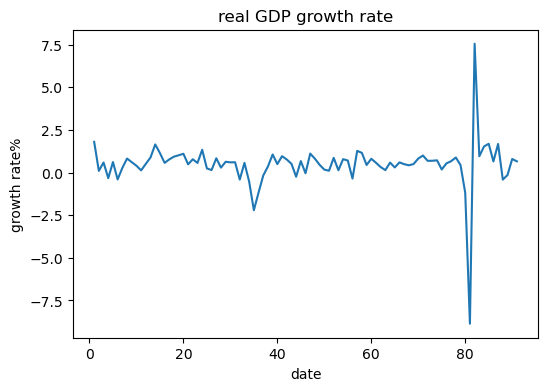

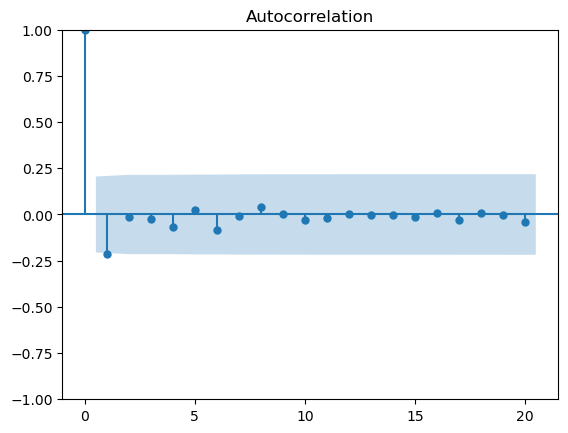

ADF Statistic: -11.7366
p-value: 0.0000
Critical Values:
1%: -3.5052
5%: -2.8942
10%: -2.5842


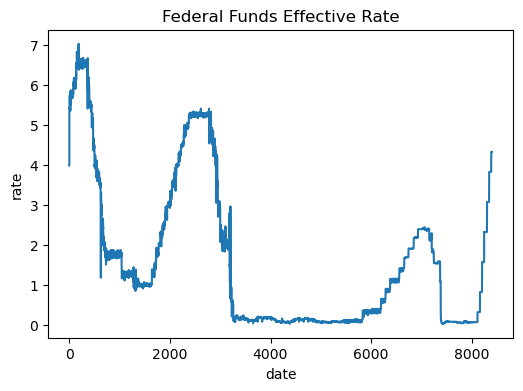

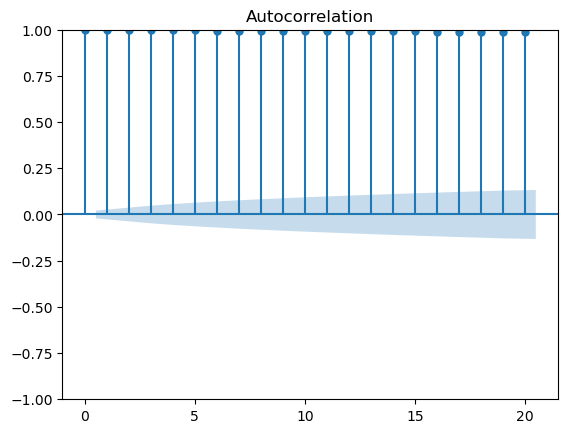

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     3176.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:31:32   Log-Likelihood:                -15821.
No. Observations:                8401   AIC:                         3.165e+04
Df Residuals:                    8399   BIC:                         3.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3392      0.035     96.171      0.0

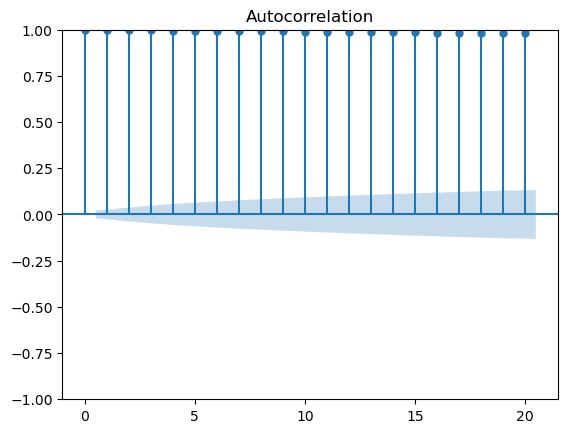

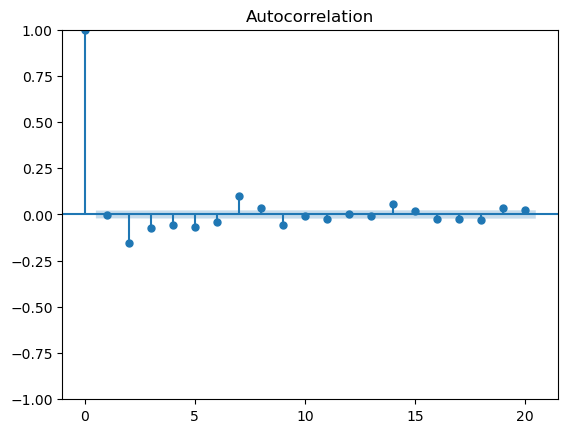

ADF Statistic: -13.8734
p-value: 0.0000
Critical Values:
1%: -3.4311
5%: -2.8619
10%: -2.5670


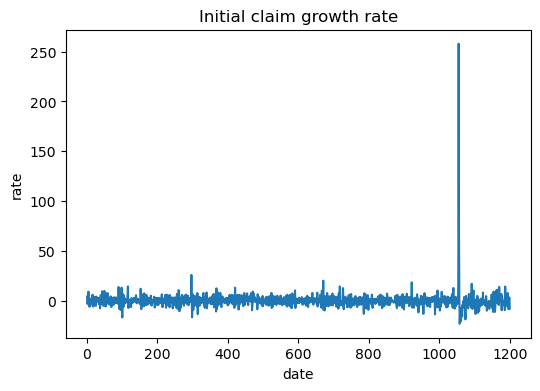

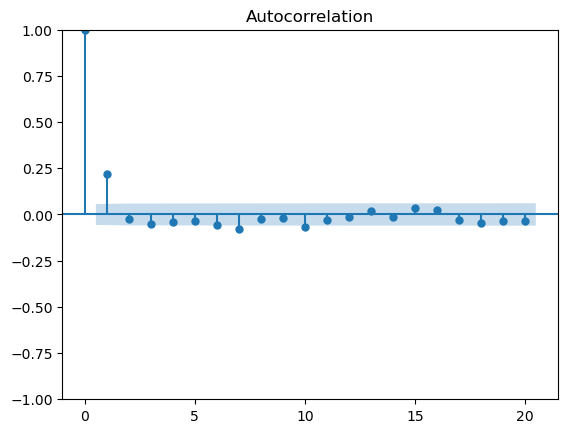

ADF Statistic: -13.1869
p-value: 0.0000
Critical Values:
1%: -3.4359
5%: -2.8640
10%: -2.5681


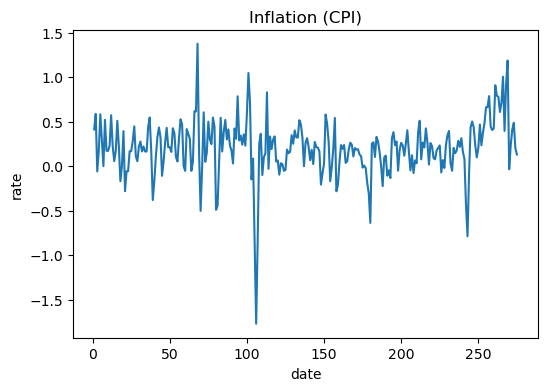

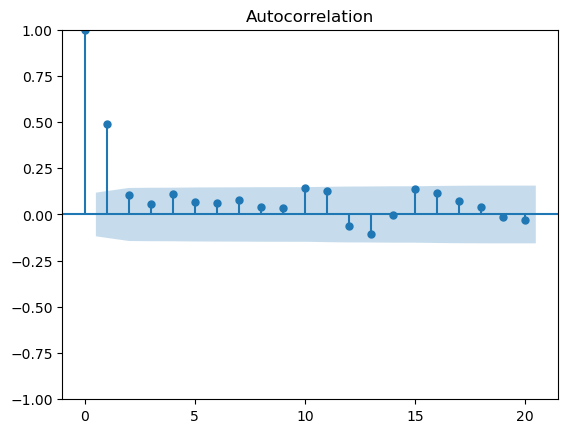

ADF Statistic: -9.9262
p-value: 0.0000
Critical Values:
1%: -3.4545
5%: -2.8722
10%: -2.5724


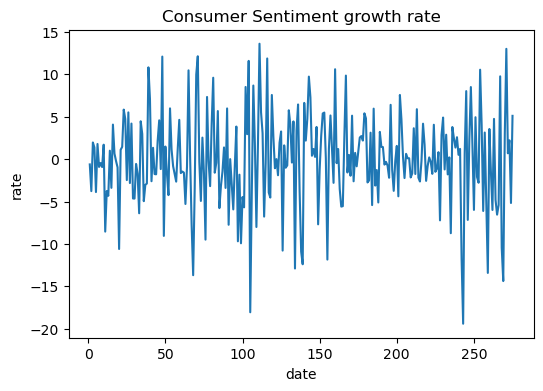

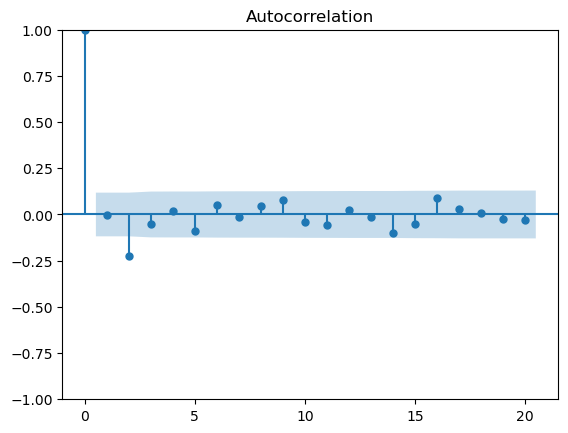

ADF Statistic: -14.6438
p-value: 0.0000
Critical Values:
1%: -3.4545
5%: -2.8722
10%: -2.5724


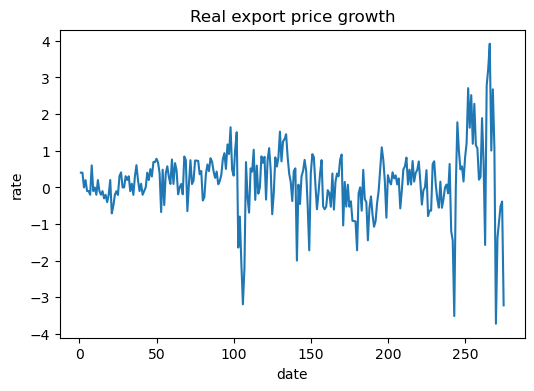

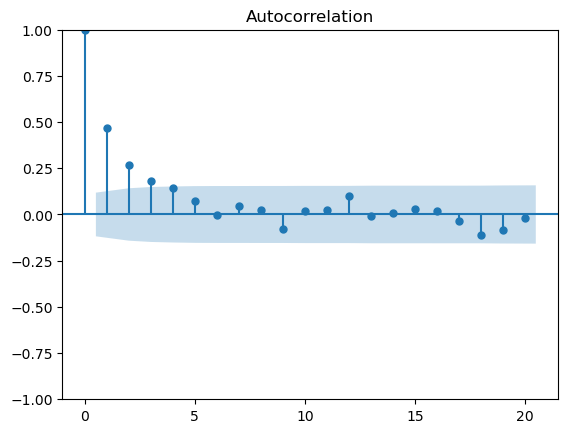

ADF Statistic: -9.2700
p-value: 0.0000
Critical Values:
1%: -3.4544
5%: -2.8721
10%: -2.5724


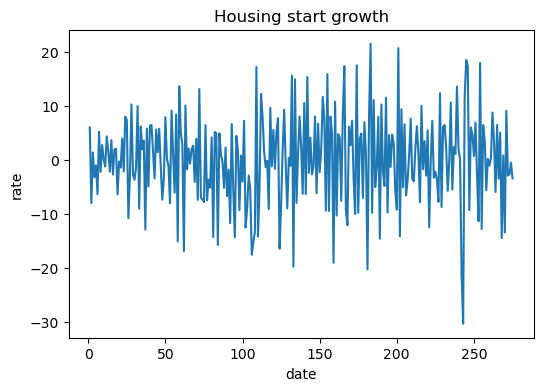

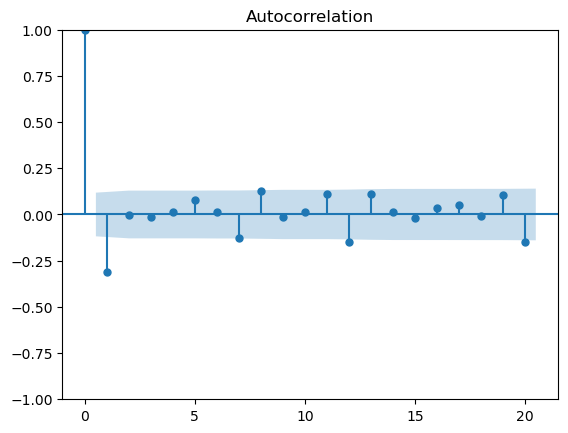

ADF Statistic: -14.8702
p-value: 0.0000
Critical Values:
1%: -3.4545
5%: -2.8722
10%: -2.5724


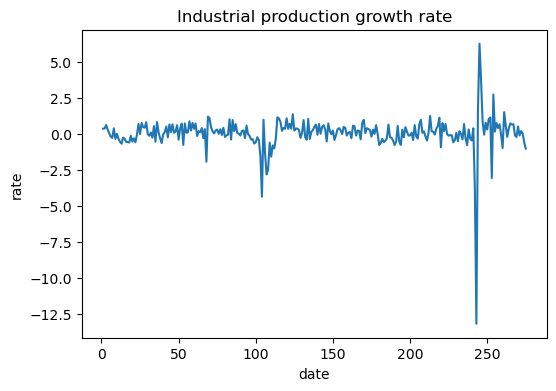

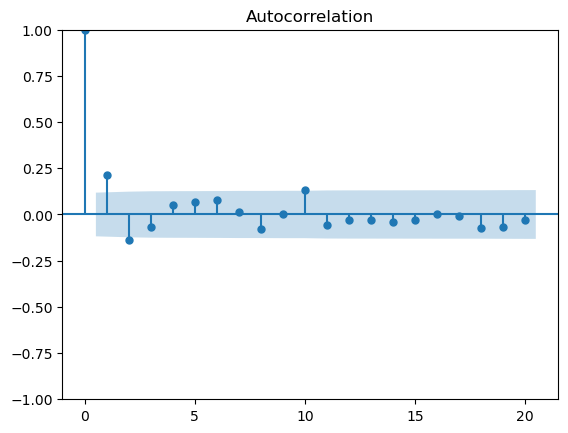

ADF Statistic: -12.4775
p-value: 0.0000
Critical Values:
1%: -3.4545
5%: -2.8722
10%: -2.5724


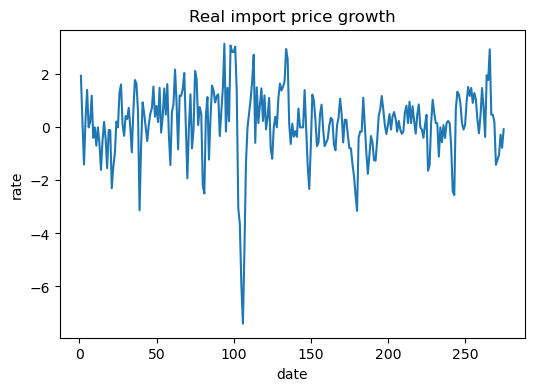

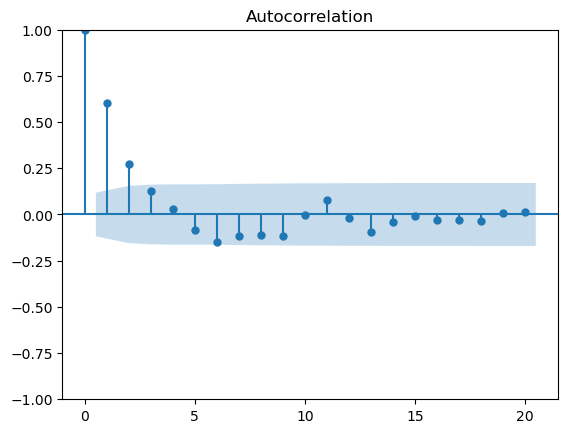

ADF Statistic: -8.4454
p-value: 0.0000
Critical Values:
1%: -3.4545
5%: -2.8722
10%: -2.5724


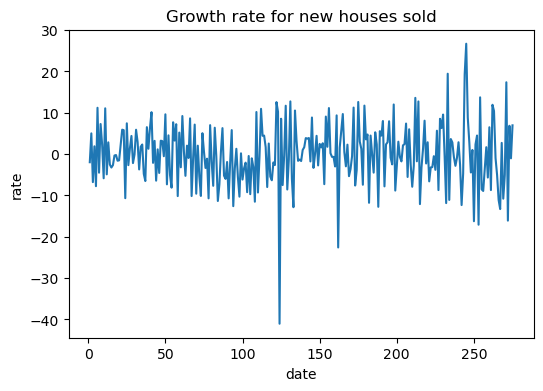

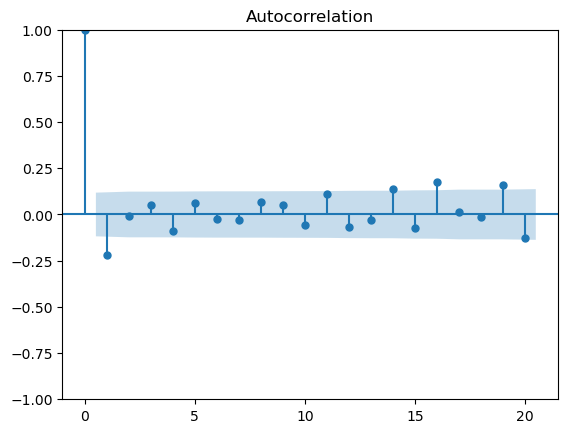

ADF Statistic: -20.5595
p-value: 0.0000
Critical Values:
1%: -3.4544
5%: -2.8721
10%: -2.5724


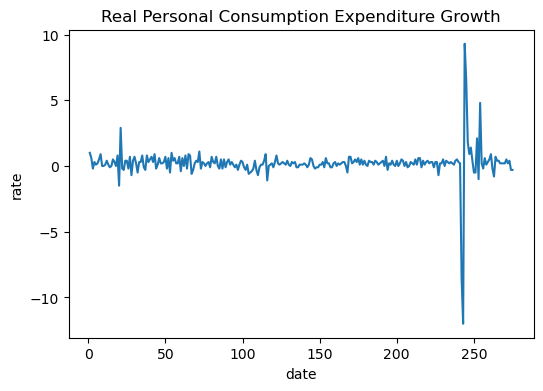

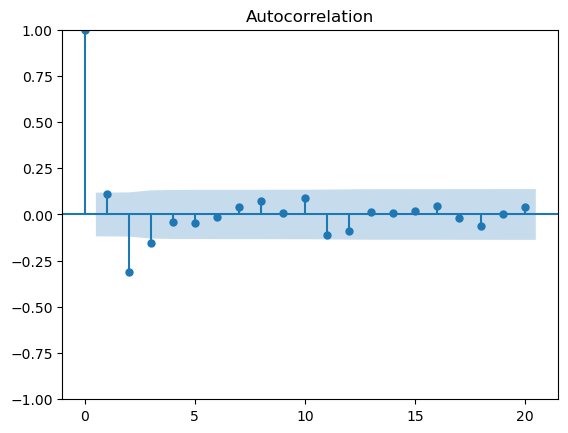

ADF Statistic: -5.9167
p-value: 0.0000
Critical Values:
1%: -3.4554
5%: -2.8726
10%: -2.5726


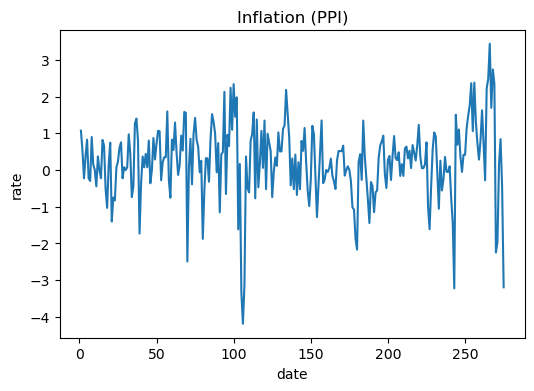

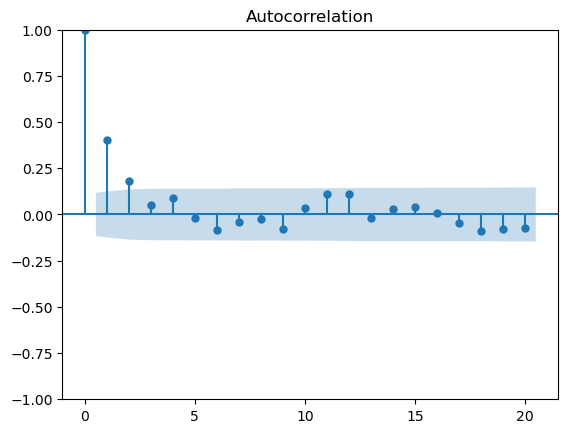

ADF Statistic: -10.2968
p-value: 0.0000
Critical Values:
1%: -3.4544
5%: -2.8721
10%: -2.5724


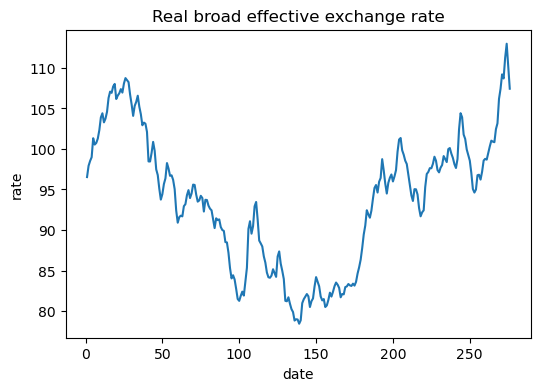

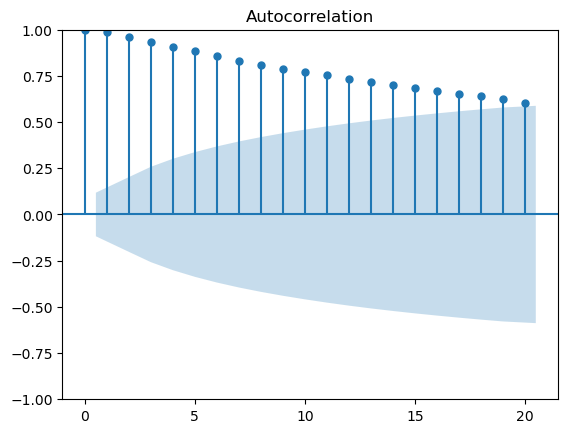

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2975
Date:                Wed, 05 Apr 2023   Prob (F-statistic):              0.586
Time:                        18:31:38   Log-Likelihood:                -974.64
No. Observations:                 276   AIC:                             1953.
Df Residuals:                     274   BIC:                             1961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.2077      1.002     94.049      0.0

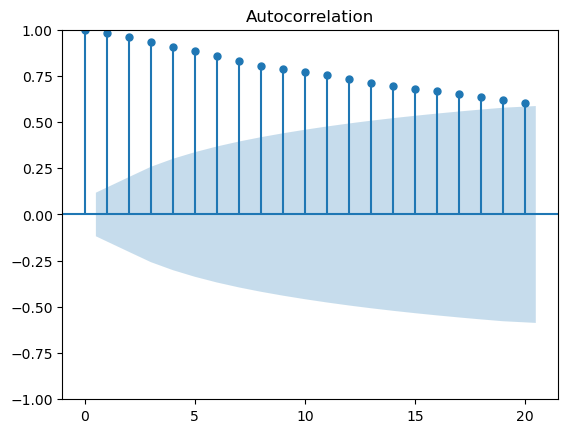

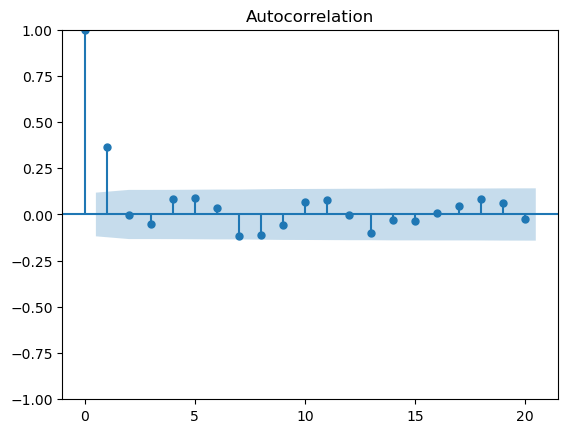

ADF Statistic: -6.9716
p-value: 0.0000
Critical Values:
1%: -3.4547
5%: -2.8723
10%: -2.5725


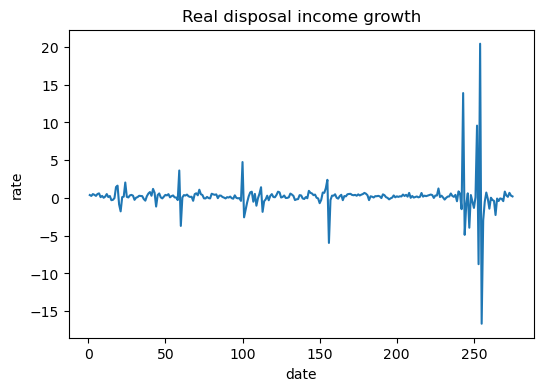

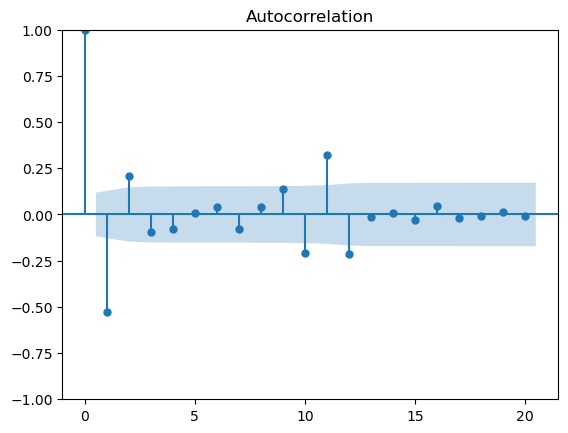

ADF Statistic: -4.2567
p-value: 0.0005
Critical Values:
1%: -3.4556
5%: -2.8726
10%: -2.5727


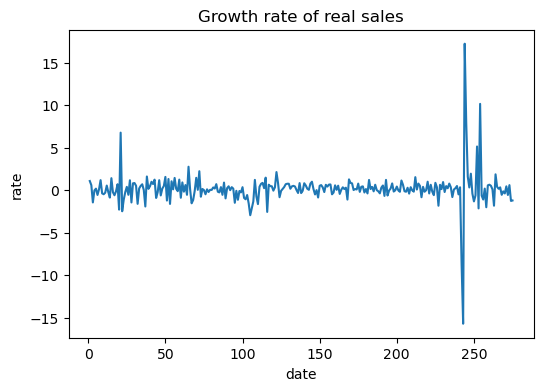

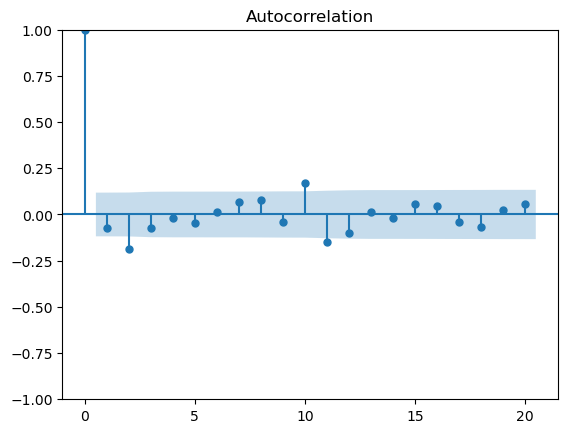

ADF Statistic: -4.5057
p-value: 0.0002
Critical Values:
1%: -3.4554
5%: -2.8726
10%: -2.5726


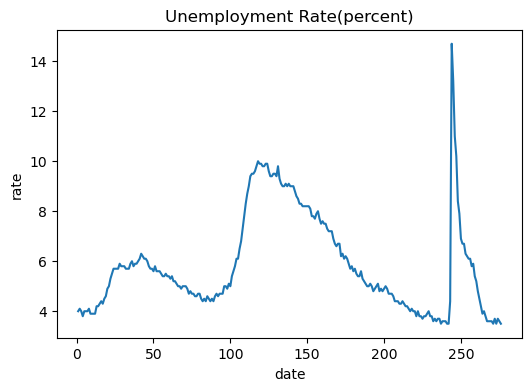

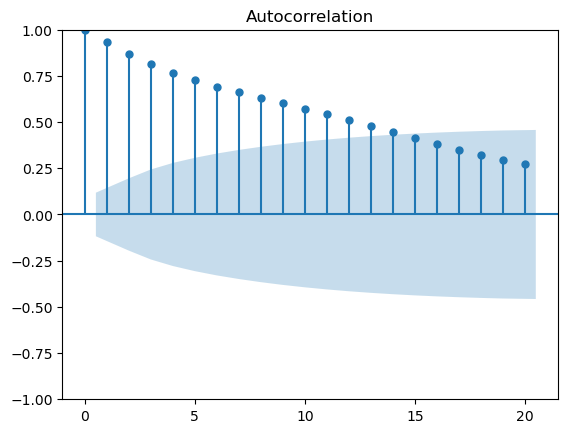

ADF Statistic: -2.8618
p-value: 0.0500
Critical Values:
1%: -3.4544
5%: -2.8721
10%: -2.5724
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4015
Date:                Wed, 05 Apr 2023   Prob (F-statistic):              0.527
Time:                        18:31:40   Log-Likelihood:                -576.57
No. Observations:                 276   AIC:                             1157.
Df Residuals:                     274   BIC:                             1164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

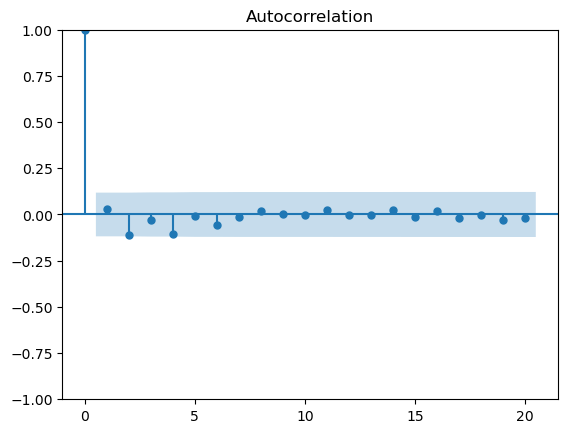

ADF Statistic: -12.8052
p-value: 0.0000
Critical Values:
1%: -3.4545
5%: -2.8722
10%: -2.5724


In [13]:
# pre-processing: plots, stationarity and unit root tests

# GDP growth rate(stationary)
  #plot of real GDP growth
fig_rgdp_growth,ax = plt.subplots(figsize=(6,4))
y1 = rgdp_growth["Real GDP growth rate"].tolist()
x1 = [i for i in range(1,len(y1)+1)]
ax.plot(x1, y1)
ax.set_title("real GDP growth rate")
ax.set_xlabel("date")
ax.set_ylabel("growth rate%")
plt.show()  
  #plot of ACF for real GDP growth(stationary)
plot_acf(y1, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y1)


# Federal Funds Effective Rate (use dffer in the future)
  #plot of Federal Funds Effective Rate
fig_ffer,ax = plt.subplots(figsize=(6,4))
y2 = ffer["Federal Funds Effective Rate"].tolist()
x2 = [i for i in range(1,len(y2)+1)]
ax.plot(x2, y2)
ax.set_title("Federal Funds Effective Rate")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()
  #plot of ACF(not stationary)
plot_acf(y2, lags=20)
plt.show()
  #check trend(significant; trending)
ffer_model = sm.OLS(y2, sm.add_constant(x2))
result2 = ffer_model.fit()
print(result2.summary())
  #remove the trend
detrend_ffer = result2.resid
  #plot ACF for detrend ffer(still not stationary)
plot_acf(detrend_ffer, lags=20)
plt.show()
  #Choose an alternative: first differencing
dffer = ffer.diff()
dffer = dffer.dropna()
y2 = dffer["Federal Funds Effective Rate"].tolist()
x2 = [i for i in range(1,len(y2)+1)]
  #plot ACF for dffer(tend to be stationary)
plot_acf(y2, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; dffer stationary)
adf_test(y2)


# growth rate of initial job claims(stationary)
  #plot 
fig_ijc_growth,ax = plt.subplots(figsize=(6,4))
y3 = ijc_growth["Initial claim growth rate"].tolist()
x3 = [i for i in range(1,len(y3)+1)]
ax.plot(x3, y3)
ax.set_title("Initial claim growth rate")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(stationary)
plot_acf(y3, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y3)


# inflation measured by CPI(stationary)
  #plot 
fig_inf_cpi,ax = plt.subplots(figsize=(6,4))
y4 = inf_cpi["Inflation (CPI)"].tolist()
x4 = [i for i in range(1,len(y4)+1)]
ax.plot(x4, y4)
ax.set_title("Inflation (CPI)")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show() 
  #plot of ACF(stationary)
plot_acf(y4, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y4)


# consumer sentiment growth rate(stationary)
  #plot 
fig_cs_growth,ax = plt.subplots(figsize=(6,4))
y5 = cs_growth["Consumer Sentiment growth rate"].tolist()
x5 = [i for i in range(1,len(y5)+1)]
ax.plot(x5, y5)
ax.set_title("Consumer Sentiment growth rate")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(stationary)
plot_acf(y5, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y5)


# export price growth (stationary)
  #plot 
fig_rep_growth,ax = plt.subplots(figsize=(6,4))
y6 = rep_growth["Real export price growth"].tolist()
x6 = [i for i in range(1,len(y6)+1)]
ax.plot(x6, y6)
ax.set_title("Real export price growth")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(tend to be stationary)
plot_acf(y6, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y6)


# housing start growth(stationary)
  #plot 
fig_hs_growth,ax = plt.subplots(figsize=(6,4))
y7 = hs_growth["Housing start growth"].tolist()
x7 = [i for i in range(1,len(y7)+1)]
ax.plot(x7, y7)
ax.set_title("Housing start growth")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(tend to be stationary)
plot_acf(y7, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y7)


# Industrial Production growth rate(stationary)
  #plot 
fig_ipro_growth,ax = plt.subplots(figsize=(6,4))
y8 = ipro_growth["Industrial production growth rate"].tolist()
x8 = [i for i in range(1,len(y8)+1)]
ax.plot(x8, y8)
ax.set_title("Industrial production growth rate")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(tend to be stationary)
plot_acf(y8, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y8)


# Import price growth(stationary)
  #plot 
fig_rip_growth,ax = plt.subplots(figsize=(6,4))
y9 = rip_growth["Real import price growth"].tolist()
x9 = [i for i in range(1,len(y9)+1)]
ax.plot(x9, y9)
ax.set_title("Real import price growth")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(tend to be stationary)
plot_acf(y9, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y9)


# Growth rate of new houses sold(stationary)
  #plot 
fig_nhs_growth,ax = plt.subplots(figsize=(6,4))
y10 = nhs_growth["Growth rate for new houses sold"].tolist()
x10 = [i for i in range(1,len(y10)+1)]
ax.plot(x10, y10)
ax.set_title("Growth rate for new houses sold")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(tend to be stationary)
plot_acf(y10, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y10)


# Growth rate for real Personal Consumption Expenditure(stationary)
  #plot 
fig_rpce_growth,ax = plt.subplots(figsize=(6,4))
y11 = rpce_growth["Real Personal Consumption Expenditure Growth"].tolist()
x11 = [i for i in range(1,len(y11)+1)]
ax.plot(x11, y11)
ax.set_title("Real Personal Consumption Expenditure Growth")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(stationary)
plot_acf(y11, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y11)


# Inflation measured by PPI(stationary)
  #plot 
fig_inf_ppi,ax = plt.subplots(figsize=(6,4))
y12 = inf_ppi["Inflation (PPI)"].tolist()
x12 = [i for i in range(1,len(y12)+1)]
ax.plot(x12, y12)
ax.set_title("Inflation (PPI)")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(stationary)
plot_acf(y12, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y12)


# Real broad effective exchange rate(use drbeer in the future)
  #plot 
fig_rbeer_100,ax = plt.subplots(figsize=(6,4))
y13 = rbeer_100["Real broad effective exchange rate"].tolist()
x13 = [i for i in range(1,len(y13)+1)]
ax.plot(x13, y13)
ax.set_title("Real broad effective exchange rate")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(not stationary)
plot_acf(y13, lags=20)
plt.show()
  #check trend(significant; trending)
rbeer_100_model = sm.OLS(y13, sm.add_constant(x13))
result13 = rbeer_100_model.fit()
print(result13.summary())
  #remove the trend
detrend_rbeer_100 = result13.resid
  #plot ACF for detrend ffer(still not stationary)
plot_acf(detrend_rbeer_100, lags=20)
plt.show()
  #Choose an alternative: first differencing
drbeer = rbeer_100.diff()
drbeer = drbeer.dropna()
y13 = drbeer["Real broad effective exchange rate"].tolist()
x13 = [i for i in range(1,len(y13)+1)]
  #plot ACF for dffer(stationary)
plot_acf(y13, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; drbeer stationary)
adf_test(y13)


# Real Disposable Personal Income Growth rate(stationary)
  #plot 
fig_rdpi_growth,ax = plt.subplots(figsize=(6,4))
y14 = rdpi_growth["Real disposal income growth"].tolist()
x14 = [i for i in range(1,len(y14)+1)]
ax.plot(x14, y14)
ax.set_title("Real disposal income growth")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(tend to be stationary)
plot_acf(y14, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y14)


# Growth rate of Real Retail and Food services sales(stationary)
  #plot 
fig_rs_growth,ax = plt.subplots(figsize=(6,4))
y15 = rs_growth["Growth rate of real sales"].tolist()
x15 = [i for i in range(1,len(y15)+1)]
ax.plot(x15, y15)
ax.set_title("Growth rate of real sales")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(stationary)
plot_acf(y15, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; stationary)
adf_test(y15)


# Unemployment rate(use dur in the future)
  #plot 
fig_ur,ax = plt.subplots(figsize=(6,4))
y16 = ur["Unemployment Rate(percent)"].tolist()
x16 = [i for i in range(1,len(y16)+1)]
ax.plot(x16, y16)
ax.set_title("Unemployment Rate(percent)")
ax.set_xlabel("date")
ax.set_ylabel("rate")
plt.show()  
  #plot of ACF(not stationary)
plot_acf(y16, lags=20)
plt.show()
  #ADF test for formal check of unit roots(p-value=0.05; not stationary)
adf_test(y16)
  #check trend(not significant; not trending)
ur_model = sm.OLS(y16, sm.add_constant(x16))
result16 = ur_model.fit()
print(result16.summary())
  #first differencing
dur = ur.diff()
dur = dur.dropna()
y16 = dur["Unemployment Rate(percent)"].tolist()
x16 = [i for i in range(1,len(y16)+1)]
  #plot ACF for dffer(stationary)
plot_acf(y16, lags=20)
plt.show()
  #ADF test for formal check of unit roots(null reject; dur stationary)
adf_test(y16)

In [14]:
# Combine data with same frequency into a single dataframe
  # Monthly data    
indexM = pd.date_range("2000-02-01", "2023-01-01", freq="M")

M_data = {"Inflation (CPI)":y4, "Consumer Sentiment growth":y5, "Real export price growth":y6,
  
        "Housing start growth":y7, "Industrial production growth rate":y8, 
        "Real import price growth":y9, "Growth rate for new houses sold":y10, 
        "Real Personal Consumption Expenditure Growth":y11, "Inflation (PPI)":y12,
       "drbeer":y13, "Real disposal income growth":y14, 
       "Growth rate of real sales":y15, "dur":y16}

combined_m = pd.DataFrame(M_data, index=indexM)
  # No need to combine weekly and daily data, as only one series for each frequency
    
    
# change the index (date format)
  # GDP published at the end of each quarter
indexQ = pd.date_range("2000-02-01", "2022-10-01", freq="Q").shift(+1, freq="Q")
Q_data = {"RGDP growth":y1}
y_total = pd.DataFrame(Q_data, index=indexQ)
  # Weekly data published at the end of each week (7th)
indexW = pd.date_range(start="2000-01-08", end="2023-01-01", freq="W").shift(-1, freq="D")
W_data = pd.DataFrame({"Initial claim growth rate":y3}, index=indexW)  
  # Daily published
indexD = pd.date_range(start="2000-01-02", end="2022-12-31", freq='D')
D_data = pd.DataFrame({"dffer":y2}, index=indexD)

Best model for Inflation (CPI):  ARIMA(0,0,3)(0,0,0)[0] intercept
Best model for Consumer Sentiment growth:  ARIMA(0,0,3)(0,0,0)[0]          
Best model for Real export price growth:  ARIMA(1,0,1)(0,0,0)[0]          
Best model for Housing start growth:  ARIMA(2,0,2)(0,0,0)[0]          
Best model for Industrial production growth rate:  ARIMA(2,0,2)(0,0,0)[0]          
Best model for Real import price growth:  ARIMA(1,0,1)(0,0,0)[0]          
Best model for Growth rate for new houses sold:  ARIMA(2,0,3)(0,0,0)[0]          
Best model for Real Personal Consumption Expenditure Growth:  ARIMA(0,1,2)(0,0,0)[0]          
Best model for Inflation (PPI):  ARIMA(1,0,0)(0,0,0)[0] intercept
Best model for drbeer:  ARIMA(0,0,1)(0,0,0)[0]          
Best model for Real disposal income growth:  ARIMA(2,0,2)(0,0,0)[0] intercept
Best model for Growth rate of real sales:  ARIMA(1,0,0)(0,0,0)[0] intercept
Best model for dur:  ARIMA(0,1,2)(0,0,0)[0]          
Best model for Initial claim growth rate:  AR

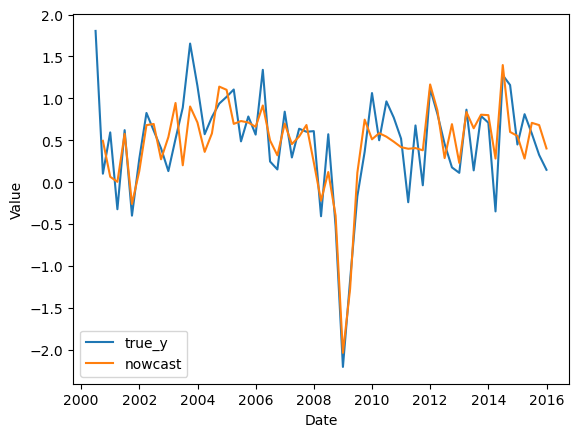

In [29]:
#Simple Bridge Equqtions: preparing initial models#

# list all initial training sets classified by frequency
# initial training set: all data published before 2016-01-31
y_train = y_total.loc[:"2015-12-31"]

X_train_M = combined_m.loc[:"2016-01-01"] 
X_train_D = D_data.loc[:"2015-12-31"]
X_train_W = W_data.loc[:"2016-01-01"]

# train ARIMA model for each indicator (initial model)
  # monthly indicator
arima_M = []
for col in X_train_M.columns:
    data = X_train_M[col]
    model = pm.auto_arima(data, seasonal=False, suppress_warnings=True, stepwise=True)
    arima_M.append(model)
    print(f"Best model for {col}:", model)
    # print(model.summary())  #to check the details delete first "#"
    
  # weekly indicator
arima_W = []
for col in X_train_W.columns:
    data = X_train_W[col]
    model = pm.auto_arima(data, seasonal=False, suppress_warnings=True, stepwise=True)
    arima_W.append(model)
    print(f"Best model for {col}:", model)
    #print(model.summary())  #to check the details delete first "#"
    
  # daily indicator
arima_D = []
for col in X_train_D.columns:
    data = X_train_D[col]
    model = pm.auto_arima(data, seasonal=False, suppress_warnings=True, stepwise=True)
    arima_D.append(model)
    print(f"Best model for {col}:", model)
    #print(model.summary())  #to check the details delete first "#"
    
# train bridge equation (initial model)
  # aggregate high frequency data to quarterly
X_train_MQ = X_train_M.resample("Q").mean()
X_train_MQ = X_train_MQ.drop(index=["2000-03-31"]) 

X_train_WQ = X_train_W.resample("Q").mean()   
X_train_WQ = X_train_WQ.drop(index=["2000-03-31"])   

X_train_DQ = X_train_D.resample("Q").mean()   
X_train_DQ = X_train_DQ.drop(index=["2000-03-31"]) 
  # combine dataframe for quarterly training set
X_train = pd.concat([X_train_MQ, X_train_WQ, X_train_DQ], axis=1)

# add lag (1)
X_train["lag1"] = y_train["RGDP growth"].shift(1)
X_train = X_train.dropna()
    
X_train = sm.add_constant(X_train)
bridgemodel = sm.OLS(y_train["RGDP growth"].tolist()[1:], X_train)
results_bridge = bridgemodel.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
print(results_bridge.summary())

  # in sample performance
insample_pred_bridge = results_bridge.predict(X_train)
predicted = insample_pred_bridge.values

insample_bridge = pd.DataFrame(predicted, index=y_total.loc["2000-09-30":"2015-12-31"].index)
plt.plot(y_train['RGDP growth'], label='true_y')
plt.plot(insample_bridge, label='nowcast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [51]:
#Simple Bridge Equqtions#
   # out of sample performance


true_y_Q = y_total.loc["2016-01-01":]
true_y_Q.index = true_y_Q.index.shift(-3, freq = "MS")
y_inter1 = true_y_Q.resample("M").ffill()
y_inter2 = pd.DataFrame({"RGDP growth": true_y_Q.loc["2022-10-01"].item()}, 
                        index = combined_m.loc["2022-11-01":].index)
true_y_M = pd.concat([y_inter1, y_inter2])

nowcast_M = []
MSE = []
test_size = len(combined_m.loc["2016-01-01":])
train_end = combined_m.index.get_loc("2015-12-31")

for i in tqdm(range(1, test_size+1),desc='progress bar'): 
    
    # generate timestep for sets
    # current_month is the end date of the month, so DWM data known
    current_month_index = train_end + i
    current_month = combined_m.index[current_month_index]
    start_of_month = current_month - pd.offsets.MonthBegin(1) 
    
    # generate current training set
    X_train_M = combined_m.loc[:current_month]
    X_train_W = W_data.loc[:current_month]
    X_train_D = D_data.loc[:current_month]
    
    if (i%3 == 1) or (i%3 == 2):  #current month is the first or second month of the current quarter
        
        target_month_index = current_month_index + (3 - i%3) 
        target_month = combined_m.index[target_month_index]
        previous_quarter = combined_m.index[target_month_index-3]
        start_of_quarter = target_month - pd.offsets.MonthBegin(3)        
        next_day_index = D_data.index.get_loc(current_month) + 1
        next_day = D_data.index[next_day_index]
        
        # known information for current quarter
        X_known_M = combined_m.loc[start_of_quarter:current_month]
        X_known_W = W_data.loc[start_of_quarter:current_month]
        X_known_D = D_data.loc[start_of_quarter:current_month] 
        
        #predictions for daily data needed
        model = arima_D[0].update(X_train_D)
        num_steps = len(D_data.loc[current_month:target_month])-1
        forecast_D = model.predict(num_steps)
        indexd = pd.date_range(start=next_day, end=target_month, freq="D")
        f_D = pd.DataFrame({"dffer":forecast_D}, index=indexd)
        
        #predictions for weekly data needed
        model = arima_W[0].update(X_train_W)
        f_W = W_data.loc[(W_data.index > current_month) & (W_data.index <= target_month)]
        num_steps = len(f_W)
        forecast_W = model.predict(num_steps)
        f_W = pd.DataFrame({"Initial claim growth rate":forecast_W}, index = f_W.index)
        
        #predictions for monthly data needed
        t = 0
        indexm = combined_m.index[current_month_index+1 : target_month_index+1]
        f_M = pd.DataFrame(index=indexm, columns= X_train_M.columns)
        
        for col in X_train_M.columns:
            data = X_train_M[col]
            model = arima_M[t].update(data)
            num_steps = 3 - i%3
            forecast_M = model.predict(num_steps)
            f_M[col] = forecast_M
            t = t + 1
        
        # Combine the predictions and the data given in test set for the current quarter
        forecastD = pd.concat([X_known_D, f_D]) 
        forecastW = pd.concat([X_known_W, f_W]) 
        forecastM = pd.concat([X_known_M, f_M]) 
        
        # lower frequency
        nowcastDQ = forecastD.resample("Q").mean()
        nowcastWQ = forecastW.resample("Q").mean()
        nowcastMQ = forecastM.resample("Q").mean()
        constant = pd.DataFrame({"const": [1] * len(nowcastMQ.index)}, index=nowcastMQ.index)
        
        # combine set and produce nowcast
        nowcast = pd.concat([constant, nowcastMQ, nowcastWQ, nowcastDQ], axis=1)  
        nowcast.loc[nowcastMQ.index, "lag1"] = y_total.loc[previous_quarter].item()
        
        prediction = results_bridge.predict(nowcast)
        predicted = prediction.values.item()
        nowcast_M.append(predicted)
        # record MSE
        true_rgdp_growth = y_total.loc[target_month]
        mse = mean_squared_error([true_rgdp_growth], [prediction])
        MSE.append(mse)
        
    else:  # current month is the end of the quarter
        start_of_quarter = current_month - pd.offsets.MonthBegin(3)
        previous_quarter = combined_m.index[current_month_index - 3]
        
        # known information for current quarter
        X_known_M = combined_m.loc[start_of_quarter:current_month]
        X_known_W = W_data.loc[start_of_quarter:current_month]
        X_known_D = D_data.loc[start_of_quarter:current_month] 
        
        # lower frequency
        nowcastDQ = X_known_D.resample("Q").mean()
        nowcastWQ = X_known_W.resample("Q").mean()
        nowcastMQ = X_known_M.resample("Q").mean()
        constant = pd.DataFrame({"const": [1] * len(nowcastMQ.index)}, index=nowcastMQ.index)
        
        # combine set and produce nowcast
        nowcast = pd.concat([constant, nowcastMQ, nowcastWQ, nowcastDQ], axis=1)
        nowcast.loc[nowcastMQ.index, "lag1"] = y_total.loc[previous_quarter].item()
        
        prediction = results_bridge.predict(nowcast)
        predicted = prediction.values.item()
        nowcast_M.append(predicted)
        # record MSE
        true_rgdp_growth = y_total.loc[current_month]
        mse = mean_squared_error([true_rgdp_growth], [prediction])
        MSE.append(mse)

progress bar: 100%|███████████████████████████| 84/84 [1:24:47<00:00, 60.56s/it]


1.9343141037540206
No retune Bridge overall:


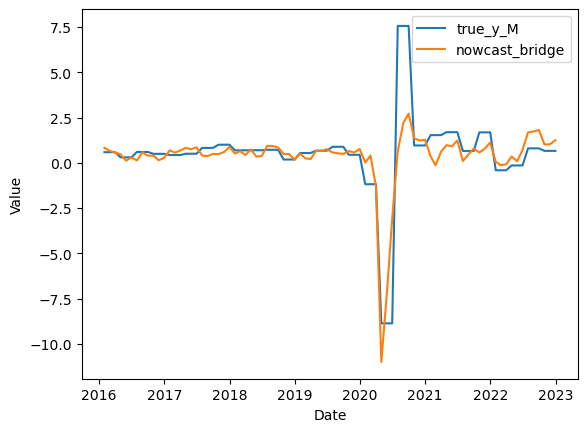

mean absolute error: 0.6823084846230628
mean absolute percentage error: 0.6256726048465173
root mean square error: 1.3907962121583524
real time root-mean-squared-forecast-error: [0.2386832530088796, 0.17761012311114152, 0.14612997278872006, 0.15308293127485456, 0.16021456227776665, 0.1462772517021568, 0.22258967704285645, 0.20826554144860307, 0.20843707733527614, 0.19978033183157815, 0.2186218768914526, 0.21812774525395426, 0.22198361043241038, 0.2168985082514672, 0.21922576291403037, 0.22683883937508023, 0.2281891837868434, 0.23701346377289928, 0.25038664893610724, 0.2643968923874832, 0.2679881460363046, 0.2841352842710226, 0.29080597058835783, 0.2858463383832417, 0.28229953382207035, 0.27698713490430527, 0.2762879803834313, 0.2714574496427406, 0.27458566394468215, 0.2761236546385562, 0.27447635029984196, 0.27265951545235284, 0.26933911777482933, 0.2705274371950185, 0.27168696967364225, 0.2679063965536935, 0.26430605766805315, 0.2649266418922498, 0.2670468972841255, 0.2636989397147717

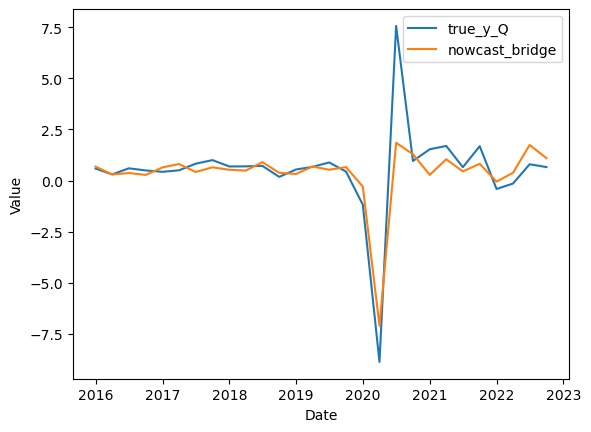

mean absolute error: 0.6184020821300662
mean absolute percentage error: 0.5923900238482833
root mean square error: 1.2221239256503083
real time root-mean-squared-forecast-error: [0.09525205774566015, 0.06737682894836458, 0.14379531720682356, 0.16599157636898948, 0.17710346091249224, 0.20478896195085122, 0.2433578704957714, 0.2593747199703647, 0.2503812754949801, 0.24638999417481341, 0.24134625869657234, 0.23808997361974596, 0.23661577947886728, 0.22805705511924235, 0.2387056999531891, 0.23748172120909267, 0.31497378307505064, 0.5167121842440611, 1.4039878249099458, 1.3704257079467153, 1.3650004000356397, 1.3408265420389902, 1.3120494098760986, 1.2964095999486158, 1.2722522122290858, 1.25180612547963, 1.2417257130720107]
mean directional accuracy: 0.7407407407407407
whole mean directional accuracy: 0.76
No retune Bridge overall before:


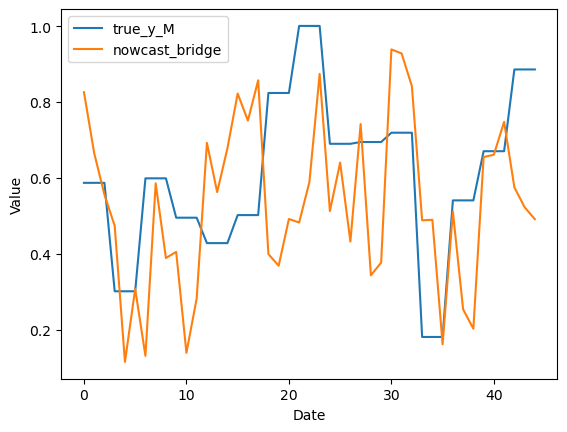

mean absolute error: 0.2246104718317245
mean absolute percentage error: 0.41580372366297863
root mean square error: 0.26544934149237737
real time root-mean-squared-forecast-error: [0.2386832530088796, 0.17761012311114152, 0.14612997278872006, 0.15308293127485456, 0.16021456227776665, 0.1462772517021568, 0.22258967704285645, 0.20826554144860307, 0.20843707733527614, 0.19978033183157815, 0.2186218768914526, 0.21812774525395426, 0.22198361043241038, 0.2168985082514672, 0.21922576291403037, 0.22683883937508023, 0.2281891837868434, 0.23701346377289928, 0.25038664893610724, 0.2643968923874832, 0.2679881460363046, 0.2841352842710226, 0.29080597058835783, 0.2858463383832417, 0.28229953382207035, 0.27698713490430527, 0.2762879803834313, 0.2714574496427406, 0.27458566394468215, 0.2761236546385562, 0.27447635029984196, 0.27265951545235284, 0.26933911777482933, 0.2705274371950185, 0.27168696967364225, 0.2679063965536935, 0.26430605766805315, 0.2649266418922498, 0.2670468972841255, 0.26369893971477

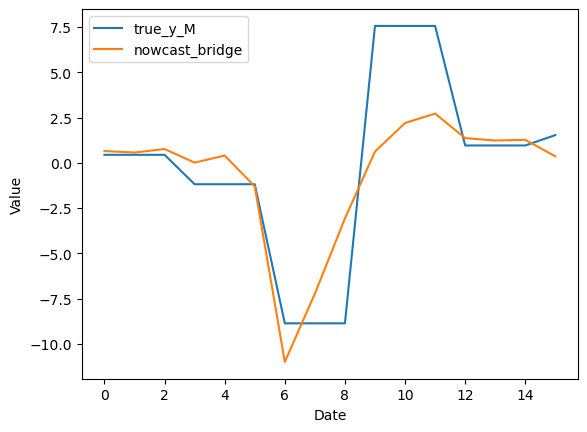

mean absolute error: 2.026176671125653
mean absolute percentage error: 0.5673763269412305
root mean square error: 3.030072189011858
real time root-mean-squared-forecast-error: [0.20906937591300612, 0.17248282817190036, 0.23238578941946245, 0.629886716031409, 0.9052459262892447, 0.8278604489303358, 1.1119140534377006, 1.190638754636889, 2.232911951968447, 3.049526661115865, 3.326669436570964, 3.478405732990915, 3.3438303825401916, 3.223029865288754, 3.1147754438218214]
mean directional accuracy: 0.26666666666666666
whole mean directional accuracy: 0.8461538461538461
No retune Bridge overall after:


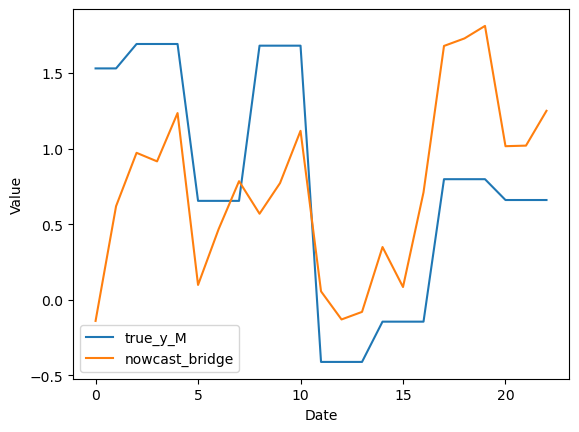

mean absolute error: 0.6429397712130102
mean absolute percentage error: 1.076839565704944
root mean square error: 0.7345550059293446
real time root-mean-squared-forecast-error: [1.6708418482028264, 1.3458936868418427, 1.1749474826136068, 1.0891185715972773, 0.9953532622974608, 0.9365850685321773, 0.8700268846194752, 0.8151378265042599, 0.8532420134318107, 0.8590142215367959, 0.8364741059433441, 0.8121322641152671, 0.7841546050078095, 0.7607907597387517, 0.7459695841959096, 0.7245522412775588, 0.7328984761896953, 0.7419537568897829, 0.7531258088710713, 0.7682898028284704, 0.7537912454090038, 0.7404469931077783]
mean directional accuracy: 0.2727272727272727
whole mean directional accuracy: 1.0


In [52]:
# Simple Bridge Equqtions: saving data & plot#
# WITHOUT RETUNE

# saving data
nowcast_bridge = pd.DataFrame({"Monthly nowcasting":nowcast_M}, index=combined_m.loc["2016-01-01":].index)
nowcast_bridge.to_csv("/Users/xuyiqi/Desktop/results/nowcast_bridge_S3.csv")
MSE_bridge = pd.DataFrame({"MSE_bridge":MSE}, index=combined_m.loc["2016-01-01":].index)
MSE_bridge.to_csv("/Users/xuyiqi/Desktop/results/MSE_bridge_S3.csv")

nowcast_M_before = nowcast_M[:45]
nowcast_M_during = nowcast_M[45:61]
nowcast_M_after = nowcast_M[61:]

print(np.mean(MSE))

#
print("No retune Bridge overall:")

plt.plot(true_y_M['RGDP growth'], label='true_y_M')
plt.plot(nowcast_bridge['Monthly nowcasting'], label='nowcast_bridge')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist(), nowcast_M)

#
print("No retune Bridge aggregated overall:")

nowcast_bridge_agg = nowcast_bridge.resample("Q").mean()
nowcast_bridge_agg = nowcast_bridge_agg.shift(-1,freq="Q").shift(+1,freq="D")

plt.plot(true_y_Q['RGDP growth'], label='true_y_Q')
plt.plot(nowcast_bridge_agg['Monthly nowcasting'], label='nowcast_bridge')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_Q['RGDP growth'].tolist(), nowcast_bridge_agg['Monthly nowcasting'].tolist())

#
print("No retune Bridge overall before:")

plt.plot(true_y_M['RGDP growth'].tolist()[:45], label='true_y_M')
plt.plot(nowcast_M[:45], label='nowcast_bridge')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[:45], nowcast_M[:45])
#
print("No retune Bridge overall during:")

plt.plot(true_y_M['RGDP growth'].tolist()[45:61], label='true_y_M')
plt.plot(nowcast_M[45:61], label='nowcast_bridge')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[45:61], nowcast_M[45:61])
#
print("No retune Bridge overall after:")

plt.plot(true_y_M['RGDP growth'].tolist()[61:], label='true_y_M')
plt.plot(nowcast_M[61:], label='nowcast_bridge')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[61:], nowcast_M[61:])


NoRetune M1


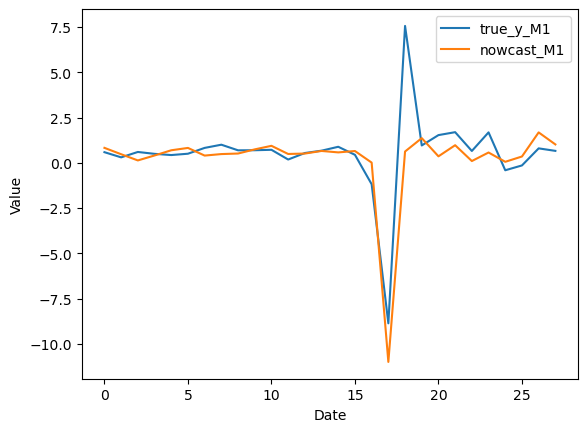

overall
mean absolute error: 0.7227113840536126
mean absolute percentage error: 0.6760293776978494
root mean square error: 1.4676241873538454
real time root-mean-squared-forecast-error: [0.2386832530088796, 0.2081409664338234, 0.3188971975967057, 0.2798186648973781, 0.27670734894932697, 0.2843792956360625, 0.3082783139328809, 0.3415408050373803, 0.3273685557998048, 0.310931078887847, 0.3037505632986313, 0.30403730104271764, 0.29222497000496966, 0.2816251426834981, 0.28361944828570795, 0.27954314018959964, 0.3967018075843696, 0.6332316588824779, 1.7066549077681308, 1.6659035437850027, 1.6457550140595778, 1.6152307183985957, 1.5839803328302449, 1.5671557964991485, 1.5383313364288478, 1.5115631962500744, 1.4929828395284386]
mean directional accuracy: 0.6666666666666666
whole mean directional accuracy: 0.56
before
mean absolute error: 0.24002562353965198
mean absolute percentage error: 0.4647670119602209
root mean square error: 0.28361944828570795
real time root-mean-squared-forecast-error

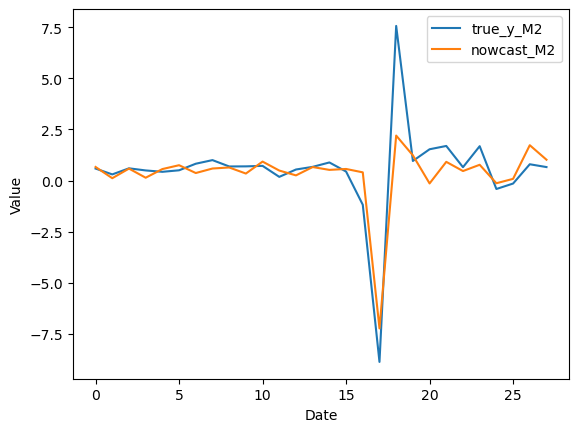

overall
mean absolute error: 0.6353574408513353
mean absolute percentage error: 0.5693713954654804
root mean square error: 1.202879445414848
real time root-mean-squared-forecast-error: [0.07823692476196165, 0.14270075478896968, 0.11676207516629679, 0.20465160171314387, 0.19264536836948887, 0.20308561665003252, 0.25478308277555195, 0.27913809489558616, 0.2636891338376463, 0.27368098895385473, 0.2684196727295812, 0.27198812084906737, 0.27316782927471855, 0.2632424691653703, 0.27101913226834506, 0.26428691782275204, 0.4619576651154133, 0.5922826910831932, 1.358254966465309, 1.3252840176099194, 1.3437557003795215, 1.323261798457334, 1.294771378775016, 1.2810284631635196, 1.2564042051609452, 1.2328257732342567, 1.2229926632703165]
mean directional accuracy: 0.7037037037037037
whole mean directional accuracy: 0.8
before
mean absolute error: 0.23058667275382516
mean absolute percentage error: 0.4519365715535899
root mean square error: 0.27101913226834506
real time root-mean-squared-forecast-e

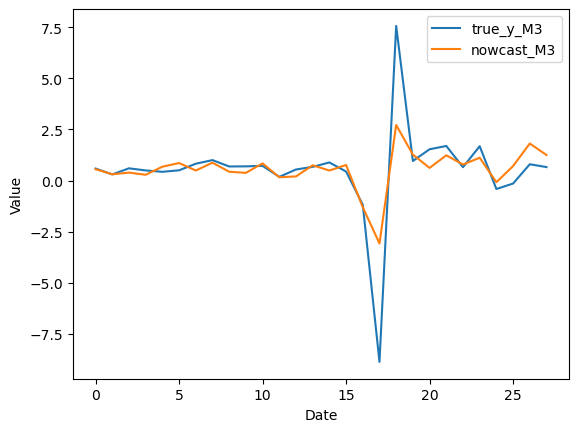

overall
mean absolute error: 0.6888566289642407
mean absolute percentage error: 0.6316170413762215
root mean square error: 1.4839483130333397
real time root-mean-squared-forecast-error: [0.031164004533861034, 0.022470775938110057, 0.12251220670628439, 0.15019446208171397, 0.17464423969583218, 0.21543164705375872, 0.23559074926238835, 0.2248470368357143, 0.22869852138255686, 0.2390677695126163, 0.23090507936959465, 0.22114541287308614, 0.2322198096678396, 0.22472401719651292, 0.23978885961369067, 0.24558466860566638, 0.24006811207127648, 1.3846751080671622, 1.7467188061212335, 1.703907200692281, 1.6747017093639283, 1.639097113631248, 1.6032987137118866, 1.573750291302602, 1.5433744308785258, 1.5226733025102597, 1.5069038268048138]
mean directional accuracy: 0.7777777777777778
whole mean directional accuracy: 0.84
before
mean absolute error: 0.20321911920169658
mean absolute percentage error: 0.3307075874751251
root mean square error: 0.23978885961369067
real time root-mean-squared-forec

In [53]:
# Non retune
nowcast_M1 = nowcast_M[0::3]
nowcast_M2 = nowcast_M[1::3]
nowcast_M3 = nowcast_M[2::3]
true_y_M1 = true_y_M['RGDP growth'].tolist()[0::3]
true_y_M2 = true_y_M['RGDP growth'].tolist()[1::3]
true_y_M3 = true_y_M['RGDP growth'].tolist()[2::3]

#
print("NoRetune M1")

plt.plot(true_y_M1, label='true_y_M1')
plt.plot(nowcast_M1, label='nowcast_M1')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M1, nowcast_M1)
print("before")
ofsperformance(true_y_M1[:15], nowcast_M1[:15])
print("during")
ofsperformance(true_y_M1[15:19], nowcast_M1[15:19])
print("during")
ofsperformance(true_y_M1[19:], nowcast_M1[19:])
#
print("NoRetune M2")

plt.plot(true_y_M2, label='true_y_M2')
plt.plot(nowcast_M2, label='nowcast_M2')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M2, nowcast_M2)
print("before")
ofsperformance(true_y_M2[:15], nowcast_M2[:15])
print("during")
ofsperformance(true_y_M2[15:19], nowcast_M2[15:19])
print("after")
ofsperformance(true_y_M2[19:], nowcast_M2[19:])

#
print("NoRetune M3")

plt.plot(true_y_M3, label='true_y_M3')
plt.plot(nowcast_M3, label='nowcast_M3')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M3, nowcast_M3)
print("before")
ofsperformance(true_y_M3[:15], nowcast_M3[:15])
print("during")
ofsperformance(true_y_M3[15:19], nowcast_M3[15:19])
print("during")
ofsperformance(true_y_M3[19:], nowcast_M3[19:])

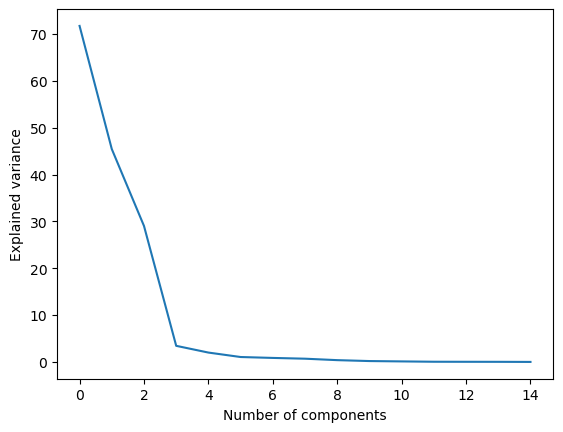

Number of common factors: 3
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     3.382
Date:                Wed, 05 Apr 2023   Prob (F-statistic):             0.0149
Time:                        21:48:52   Log-Likelihood:                -43.078
No. Observations:                  62   AIC:                             96.16
Df Residuals:                      57   BIC:                             106.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1960   

TypeError: float() argument must be a string or a number, not 'Period'

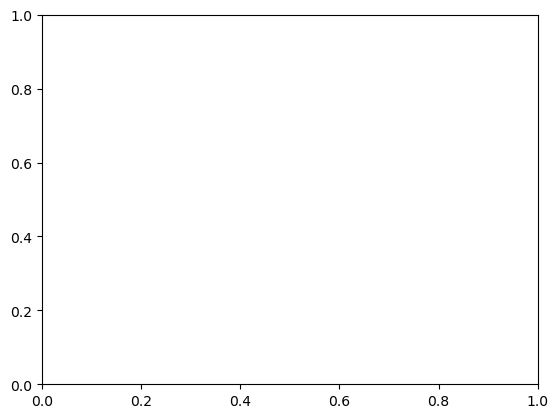

In [72]:
# Dynamic factor model

# Slip dataset: initial training set and initial test set

y_train = y_total.loc[:"2015-12-31"]

X_train_M = combined_m.loc[:"2016-01-01"] 
X_train_D = D_data.loc[:"2015-12-31"]
X_train_W = W_data.loc[:"2016-01-01"]

X_train_DM = X_train_D.resample("M").mean()
X_train_DM = X_train_DM.drop(index=["2000-01-31"])  
X_train_WM = X_train_W.resample("M").mean()
X_train_WM = X_train_WM.drop(index=["2000-01-31"])  

index_ind = pd.period_range(start="2000-02-29", periods=191, freq="M")
indicators = pd.concat([X_train_M, X_train_WM, X_train_DM], axis=1)
indicators.index = index_ind

trained_factor_estimates = []

#Step 1
# (training set) Principal component analysis: identify the number of principal components

pca = PCA()
pca.fit(indicators)
eigenvalues = pca.explained_variance_
plt.plot(eigenvalues)
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()
num_factors = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.8) + 1
print("Number of common factors:", num_factors)

n_factors = 3

# train DFM and OLS bridge

mod = DynamicFactor(indicators, k_factors=n_factors, factor_order=1, error_order=0)
initial_res = mod.fit(method='powell', disp=False)
factor_est = mod.smooth(initial_res.params)

trained_factor_estimates.append(factor_est.factors.filtered)

train = initial_res.factors.smoothed
Q_train = pd.DataFrame({"0": train[0], "1": train[1],"2": train[2]},index=indicators.index).resample("Q").mean()
Q_train = Q_train.drop(index=["2000-03-31"]) 

# add lag (1)
y_DFM_train = y_train
y_DFM_train.index = Q_train.index
Q_train["lag1"] = y_DFM_train["RGDP growth"].shift(1)
Q_train = Q_train.dropna()

Q_train = sm.add_constant(Q_train)
DFMmodel = sm.OLS(y_train["RGDP growth"].tolist()[1:], Q_train)
results_DFM = DFMmodel.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
print(results_DFM.summary())

# in sample performance

train_factors = factor_est.factors.smoothed
Q_factors = pd.DataFrame({"0": train_factors[0], "1": train_factors[1],
              "2": train_factors[2]}, index=indicators.index).resample("Q").mean()

Q_factors = Q_factors.drop(index=["2000-03-31"])
Q_factors["lag1"] = y_DFM_train["RGDP growth"].shift(1)
Q_factors = Q_factors.dropna()
Q_factors = sm.add_constant(Q_factors)

insample_predicted_DFM = results_DFM.predict(Q_factors)
insample_DFM = pd.DataFrame(insample_predicted_DFM.values, index=y_total.loc["2000-09-30":"2015-12-31"].index)

plt.plot(y_train.loc["2000-09-30":"2015-12-31"], label='true_y')
plt.plot(insample_DFM, label='nowcast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

is_MSEdfm = mean_squared_error(y_train.values[:,0], insample_predicted_DFM.values)
print("in sample MSE:", is_MSEdfm)

In [74]:
# Dynamic factor model: out of sample performance

nowcast_DFM_M = []
MSE_DFM = []
test_size = len(combined_m.loc["2016-01-01":])
train_end = combined_m.index.get_loc("2015-12-31")
test_factor_estmates = pd.DataFrame(columns=["0", "1", "2"])

for i in tqdm(range(1, test_size+1),desc='progress bar'): 
    
    # generate timestep for sets
    # current_month is the end date of the month, so DWM data known
    
    current_month_index = train_end + i
    current_month = combined_m.index[current_month_index]
    start_of_month = current_month - pd.offsets.MonthBegin(1) 
    
    # generate set for new observations of current month
    
    observed_test_D = D_data.loc[(D_data.index > start_of_month) & (D_data.index <=current_month)] 
    observed_test_D = observed_test_D.resample("M").mean()
    
    observed_test_W = W_data.loc[(W_data.index > start_of_month) & (W_data.index <=current_month)] 
    observed_test_W = observed_test_W.resample("M").mean()
    
    observed_test_M = combined_m.loc[(combined_m.index > start_of_month) & (combined_m.index <=current_month)] 
    
    observed_test = pd.concat([observed_test_M, observed_test_W, observed_test_D], axis=1)
    index_test = pd.period_range(start=current_month, periods=1, freq="M")
    observed_test.index = index_test
    
    # factor estimates for current month
    
    factor_estimates = factor_est.apply(observed_test)
    new_fac = {"0": factor_estimates.factors.smoothed[0,0], 
                "1": factor_estimates.factors.smoothed[1,0], 
                "2": factor_estimates.factors.smoothed[2,0]}
    
    test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)   
    
    # forecasted factor estimates for the following months in the current quarter (first/second month)

    if (i%3 == 1) or (i%3 == 2):
        
        Num = i%3
        target_month_index = current_month_index + (3 - Num) 
        target_month = combined_m.index[target_month_index]
        previous_quarter = combined_m.index[target_month_index-3]
        
        start_of_quarter = current_month - pd.offsets.MonthBegin(Num)
        index_quarter = pd.period_range(start=start_of_quarter, periods=3, freq="M")
        
        forecast_obs = factor_estimates.forecast(3-Num)
        forecast_factors = factor_estimates.apply(forecast_obs)
        
        # Combined factor estimates for current quarter
         
        F_est = test_factor_estmates.loc[i-Num:i-1] #Filtered and Smoothed are different
        
        forecast_F = pd.DataFrame({"0": forecast_factors.factors.smoothed[0,:].tolist(), 
                "1": forecast_factors.factors.smoothed[1,:].tolist(), 
                "2": forecast_factors.factors.smoothed[2,:].tolist()})
        
        F_currentQ = pd.concat([F_est, forecast_F], ignore_index=True)
        F_currentQ.index = index_quarter
        F_currentQ = F_currentQ.resample("Q").mean()
        F_currentQ.loc[F_currentQ.index, "lag1"] = y_total.loc[previous_quarter].item()
        
    # use current quarter's factor estimates directly if it is the last month
    else:
        target_month = current_month
        previous_quarter = combined_m.index[current_month_index - 3]
        start_of_quarter = current_month - pd.offsets.MonthBegin(3)
        index_quarter = pd.period_range(start=start_of_quarter, periods=3, freq="M")
        
        F_currentQ = test_factor_estmates.loc[i-3:i-1]
        F_currentQ.index = index_quarter
        F_currentQ = F_currentQ.resample("Q").mean()
        F_currentQ.loc[F_currentQ.index, "lag1"] = y_total.loc[previous_quarter].item()
        
    # use the OLS to make prediction for GDP growth rate
    
    F_currentQ.insert(0, "Constant", 1)
    prediction = results_DFM.predict(F_currentQ)
    predicted = prediction.values.item()
    nowcast_DFM_M.append(predicted)
        
    # record MSE
        
    true_rgdp_growth = y_total.loc[target_month]
    mse = mean_squared_error([true_rgdp_growth], [prediction])
    MSE_DFM.append(mse)

progress bar:   0%|                                      | 0/84 [00:00<?, ?it/s]/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
progress bar:   2%|▋                             | 2/84 [00:00<00:04, 17.50it/s]/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_

progress bar:  30%|████████▋                    | 25/84 [00:01<00:03, 16.56it/s]/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
progress bar:  33%|█████████▋

/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
progress bar:  62%|█████████████████▉           | 52/84 [00:02<00:01, 22.48it/s]/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1

/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
progress bar:  94%|███████████████████████████▎ | 79/84 [00:03<00:00, 20.73it/s]/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_30309/3943469847.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_factor_estmates = test_factor_estmates.append(new_fac, ignore_index=True)
/var/folders/nm/mxqq3mvn68xd1

/Users/xuyiqi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE_DFM    4.7221
dtype: float64
No retune DFM overall:


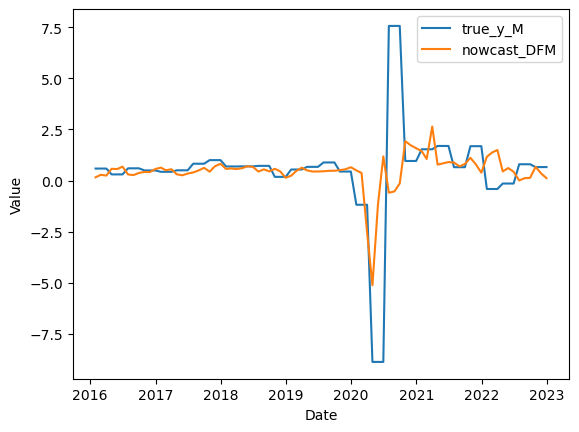

mean absolute error: 0.9598314671794098
mean absolute percentage error: 0.8041734637260367
root mean square error: 2.173039268363782
real time root-mean-squared-forecast-error: [0.4293906404672174, 0.37203591881732984, 0.36270977331175464, 0.3427956450844204, 0.32792800536108313, 0.3369752178206171, 0.33214868648816553, 0.3317369689746322, 0.3216968435952646, 0.30605080563005677, 0.2928021631384574, 0.28105552935559447, 0.275940652707565, 0.2666677382032004, 0.2596490891904138, 0.2561151783064288, 0.2554065191182768, 0.25107534200557774, 0.26317572287934377, 0.26659321989019014, 0.2638263324658001, 0.28471964241682785, 0.2853562680761528, 0.28176630566659827, 0.2771379099118165, 0.2724282371159662, 0.2684111282188757, 0.2641252207512737, 0.2595327047102486, 0.2552097832368829, 0.2559375458429395, 0.2536948176033542, 0.2542488697039386, 0.2594869230631679, 0.25975570112629176, 0.2562256736734767, 0.25748911870086405, 0.2543554624368246, 0.25145671394451435, 0.24983046393567165, 0.249341

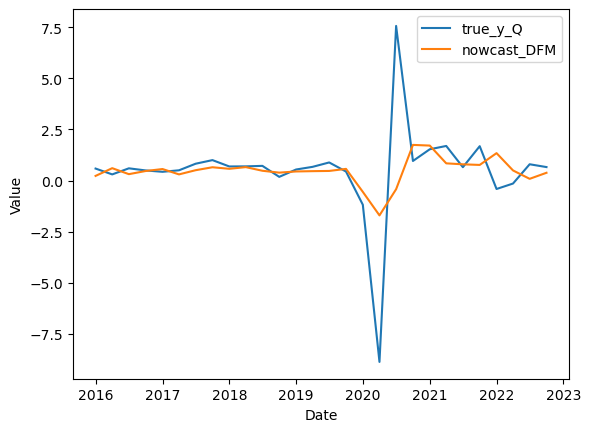

mean absolute error: 0.9092446234750817
mean absolute percentage error: 0.7549410977943897
root mean square error: 2.0932942499419056
real time root-mean-squared-forecast-error: [0.358912265032333, 0.3328347319779572, 0.3178161401895069, 0.27558404242131623, 0.2537987958282946, 0.24564440477183258, 0.2570624151670973, 0.27025444857832637, 0.2576423039031246, 0.24469722522098997, 0.24422485860894377, 0.24132472855636297, 0.23335910663940232, 0.231763490543702, 0.24818959904365556, 0.2424867166891882, 0.2804677709423852, 1.7104947579373924, 2.475074365705555, 2.418794187104157, 2.360829135072438, 2.3136559356475597, 2.262989606637142, 2.2232250216306118, 2.2063289153511483, 2.1671292835729914, 2.1310307573909335]
mean directional accuracy: 0.4444444444444444
whole mean directional accuracy: 0.64
No retune DFM overall before:


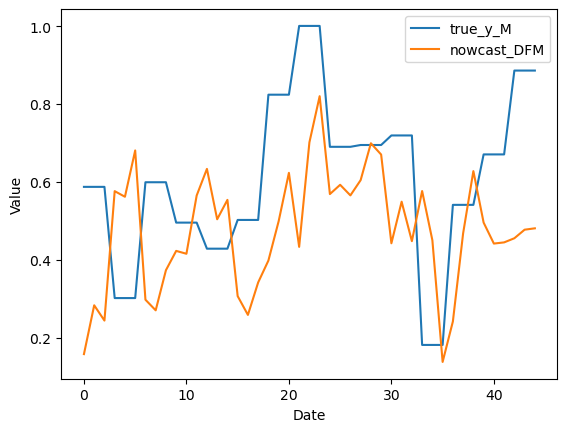

mean absolute error: 0.22875055502271613
mean absolute percentage error: 0.44067407213170245
root mean square error: 0.2631567371468521
real time root-mean-squared-forecast-error: [0.4293906404672174, 0.37203591881732984, 0.36270977331175464, 0.3427956450844204, 0.32792800536108313, 0.3369752178206171, 0.33214868648816553, 0.3317369689746322, 0.3216968435952646, 0.30605080563005677, 0.2928021631384574, 0.28105552935559447, 0.275940652707565, 0.2666677382032004, 0.2596490891904138, 0.2561151783064288, 0.2554065191182768, 0.25107534200557774, 0.26317572287934377, 0.26659321989019014, 0.2638263324658001, 0.28471964241682785, 0.2853562680761528, 0.28176630566659827, 0.2771379099118165, 0.2724282371159662, 0.2684111282188757, 0.2641252207512737, 0.2595327047102486, 0.2552097832368829, 0.2559375458429395, 0.2536948176033542, 0.2542488697039386, 0.2594869230631679, 0.25975570112629176, 0.2562256736734767, 0.25748911870086405, 0.2543554624368246, 0.25145671394451435, 0.24983046393567165, 0.249

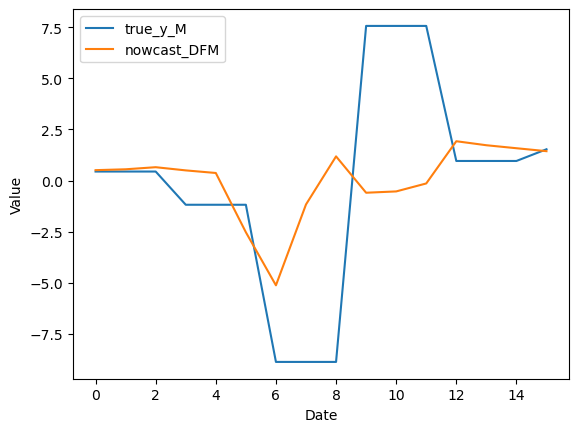

mean absolute error: 3.303751562496501
mean absolute percentage error: 0.8040464669338983
root mean square error: 4.838722035162144
real time root-mean-squared-forecast-error: [0.06748746485059565, 0.09113791109815507, 0.14316848529772114, 0.8492057164100034, 1.0293273421232778, 1.0882412250304911, 1.7375106213134217, 3.1702483656907376, 4.489278185783488, 4.978925119887549, 5.33741289115634, 5.572938982136563, 5.360992626535756, 5.170070595982953, 4.997352641030319]
mean directional accuracy: 0.13333333333333333
whole mean directional accuracy: 0.5384615384615384
No retune DFM overall after:


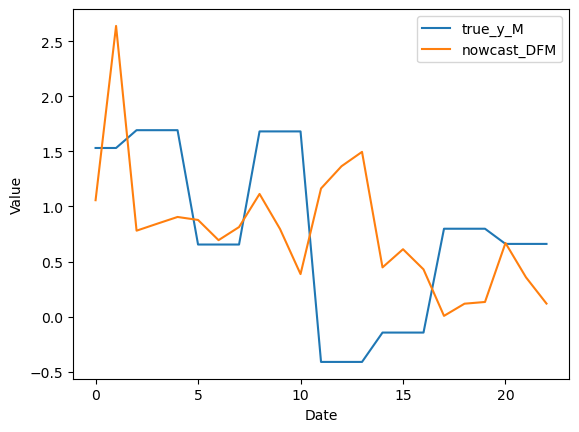

mean absolute error: 0.7596540550914854
mean absolute percentage error: 1.5154562711355692
root mean square error: 0.9071781519277284
real time root-mean-squared-forecast-error: [0.4740862803992292, 0.8522395430730412, 0.8727119650661223, 0.8669722201439588, 0.8517305676706602, 0.782837858161746, 0.7249216931831531, 0.6804153674808329, 0.6688325825622362, 0.6936211389270038, 0.7680484895624108, 0.8644723982160422, 0.9657193622864136, 1.0609971819051403, 1.0363442298935495, 1.0211068624104498, 1.0003473497931372, 0.9898821858737488, 0.9760478953895827, 0.9628831483174527, 0.9396795047507464, 0.9203501900940353]
mean directional accuracy: 0.09090909090909091
whole mean directional accuracy: 0.25


In [75]:
# DFM: saving data & plot#
# WITHOUT RETUNE

# saving data
nowcast_DFM = pd.DataFrame({"Monthly nowcasting":nowcast_DFM_M}, index=combined_m.loc["2016-01-01":].index)
nowcast_DFM.to_csv("/Users/xuyiqi/Desktop/results/nowcast_DFM_S3.csv")
MSE_DFM = pd.DataFrame({"MSE_DFM":MSE_DFM}, index=combined_m.loc["2016-01-01":].index)
MSE_DFM.to_csv("/Users/xuyiqi/Desktop/results/MSE_DFM_S3.csv")

nowcast_DFM_M_before = nowcast_DFM_M[:45]
nowcast_DFM_M_during = nowcast_DFM_M[45:61]
nowcast_DFM_M_after = nowcast_DFM_M[61:]

print(np.mean(MSE_DFM))

#
print("No retune DFM overall:")

plt.plot(true_y_M['RGDP growth'], label='true_y_M')
plt.plot(nowcast_DFM['Monthly nowcasting'], label='nowcast_DFM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist(), nowcast_DFM_M)

#
print("No retune DFM aggregated overall:")

nowcast_DFM_agg = nowcast_DFM.resample("Q").mean()
nowcast_DFM_agg = nowcast_DFM_agg.shift(-1,freq="Q").shift(+1,freq="D")

plt.plot(true_y_Q['RGDP growth'], label='true_y_Q')
plt.plot(nowcast_DFM_agg['Monthly nowcasting'], label='nowcast_DFM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_Q['RGDP growth'].tolist(), nowcast_DFM_agg['Monthly nowcasting'].tolist())

#
print("No retune DFM overall before:")

plt.plot(true_y_M['RGDP growth'].tolist()[:45], label='true_y_M')
plt.plot(nowcast_DFM_M[:45], label='nowcast_DFM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[:45], nowcast_DFM_M[:45])
#
print("No retune DFM overall during:")

plt.plot(true_y_M['RGDP growth'].tolist()[45:61], label='true_y_M')
plt.plot(nowcast_DFM_M[45:61], label='nowcast_DFM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[45:61], nowcast_DFM_M[45:61])
#
print("No retune DFM overall after:")

plt.plot(true_y_M['RGDP growth'].tolist()[61:], label='true_y_M')
plt.plot(nowcast_DFM_M[61:], label='nowcast_DFM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[61:], nowcast_DFM_M[61:])


NoRetune M1


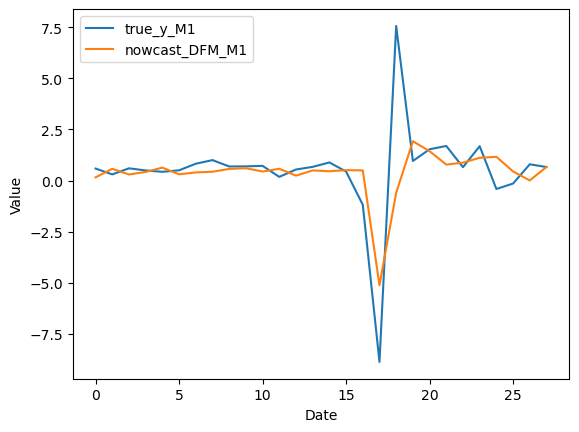

overall
mean absolute error: 0.844129352155324
mean absolute percentage error: 0.8102815449168332
root mean square error: 1.797505888694919
real time root-mean-squared-forecast-error: [0.4293906404672174, 0.3603724464416151, 0.3418976773382212, 0.2983091051926983, 0.28210243940952845, 0.2696182306477694, 0.2969927393042558, 0.342632793191546, 0.3255592370237046, 0.31016715535979317, 0.30729028138651904, 0.3155466344243535, 0.3143372273658844, 0.3064921754412909, 0.3162771116069907, 0.3066984194417287, 0.5045750965734175, 1.0098162871559784, 2.1134843597445006, 2.0712419595308007, 2.0214275808053057, 1.9845060388098668, 1.9414427476034515, 1.904095490691776, 1.8920124558360047, 1.8588965760149267, 1.8304896926137038]
mean directional accuracy: 0.2962962962962963
whole mean directional accuracy: 0.36
before
mean absolute error: 0.28399983751996144
mean absolute percentage error: 0.560427677918975
root mean square error: 0.3162771116069907
real time root-mean-squared-forecast-error: [0.42

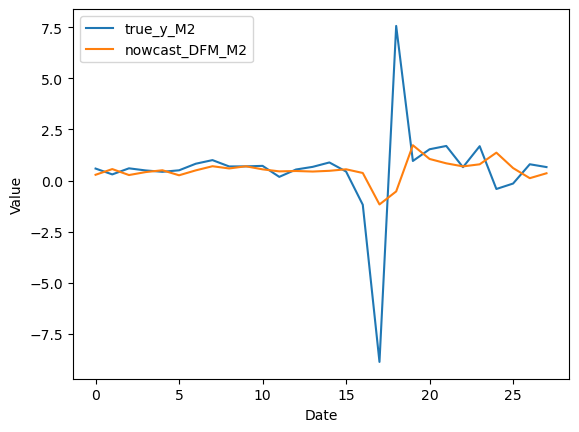

overall
mean absolute error: 0.9698671524216503
mean absolute percentage error: 0.8145357094680126
root mean square error: 2.192890487465442
real time root-mean-squared-forecast-error: [0.30404790356070954, 0.28292542657454783, 0.29901486982528286, 0.26202237260679817, 0.23678018571955325, 0.23796248266688985, 0.25219833340960807, 0.25851512148829403, 0.24588858596674923, 0.23327464229045305, 0.22825417931923112, 0.23189756598607233, 0.22372175548631973, 0.22409615827012586, 0.24082763112396072, 0.23479071777574434, 0.440253896634894, 1.8643764950694972, 2.5959176600724607, 2.5360269691082857, 2.4770702122251285, 2.426886317544379, 2.373556017949839, 2.3306091616977502, 2.3109995045421576, 2.270973824483631, 2.2323670706735537]
mean directional accuracy: 0.4444444444444444
whole mean directional accuracy: 0.64
before
mean absolute error: 0.2111601212213103
mean absolute percentage error: 0.41629562378104357
root mean square error: 0.24082763112396072
real time root-mean-squared-forecas

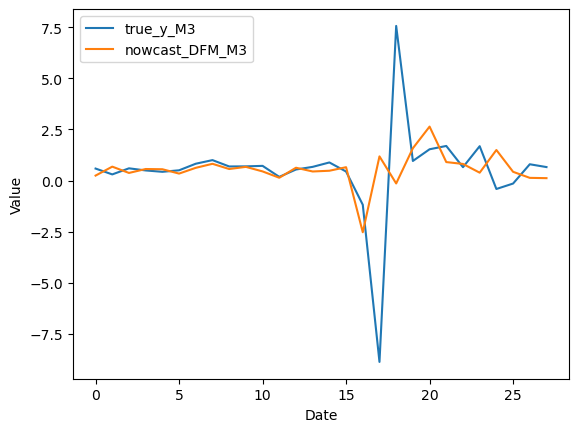

overall
mean absolute error: 1.0654978969612545
mean absolute percentage error: 0.7877031367932638
root mean square error: 2.4751773422612917
real time root-mean-squared-forecast-error: [0.3432982510690721, 0.36158234901478864, 0.32274241027724765, 0.28166040857155644, 0.25808197512038994, 0.24453291932790938, 0.2387557633504061, 0.2322702176747172, 0.22289815552176545, 0.2116019314177576, 0.21771581436792622, 0.20882678932905013, 0.20206959340130218, 0.20386105345282576, 0.22299158207899447, 0.22231145003126454, 0.3909865342921508, 2.3988141520899604, 2.9280999296176815, 2.857357139881534, 2.798959527539879, 2.7397604793323302, 2.6797425655084446, 2.636611188802108, 2.61133893024334, 2.563100132860235, 2.518440863402155]
mean directional accuracy: 0.4444444444444444
whole mean directional accuracy: 0.6
before
mean absolute error: 0.19109170632687666
mean absolute percentage error: 0.3452989146950887
root mean square error: 0.22299158207899447
real time root-mean-squared-forecast-error

In [76]:
# Non retune
nowcast_DFM_M1 = nowcast_DFM_M[0::3]
nowcast_DFM_M2 = nowcast_DFM_M[1::3]
nowcast_DFM_M3 = nowcast_DFM_M[2::3]
true_y_M1 = true_y_M['RGDP growth'].tolist()[0::3]
true_y_M2 = true_y_M['RGDP growth'].tolist()[1::3]
true_y_M3 = true_y_M['RGDP growth'].tolist()[2::3]

#
print("NoRetune M1")

plt.plot(true_y_M1, label='true_y_M1')
plt.plot(nowcast_DFM_M1, label='nowcast_DFM_M1')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M1, nowcast_DFM_M1)
print("before")
ofsperformance(true_y_M1[:15], nowcast_DFM_M1[:15])
print("during")
ofsperformance(true_y_M1[15:19], nowcast_DFM_M1[15:19])
print("after")
ofsperformance(true_y_M1[19:], nowcast_DFM_M1[19:])
#
print("NoRetune M2")

plt.plot(true_y_M2, label='true_y_M2')
plt.plot(nowcast_DFM_M2, label='nowcast_DFM_M2')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M2, nowcast_DFM_M2)
print("before")
ofsperformance(true_y_M2[:15], nowcast_DFM_M2[:15])
print("during")
ofsperformance(true_y_M2[15:19], nowcast_DFM_M2[15:19])
print("after")
ofsperformance(true_y_M2[19:], nowcast_DFM_M2[19:])

#
print("NoRetune M3")

plt.plot(true_y_M3, label='true_y_M3')
plt.plot(nowcast_DFM_M3, label='nowcast_DFM_M3')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M3, nowcast_DFM_M3)
print("before")
ofsperformance(true_y_M3[:15], nowcast_DFM_M3[:15])
print("during")
ofsperformance(true_y_M3[15:19], nowcast_DFM_M3[15:19])
print("after")
ofsperformance(true_y_M3[19:], nowcast_DFM_M3[19:])

In [138]:
# Random Forest

y_train = y_total.loc[:"2015-12-31"]

X_train_M = combined_m.loc[:"2016-01-01"] 
X_train_D = D_data.loc[:"2015-12-31"]
X_train_W = W_data.loc[:"2015-12-31"]

y_test= y_total.loc["2015-12-31":]

X_test_M = combined_m.loc["2016-01-01":] 
X_test_D = D_data.loc["2016-01-01":]
X_test_W = W_data.loc["2016-01-01":]

In [139]:
def supToMonth(D):
    currentMonth = None
    counter = 0
    data = []
    figure = 0
    for idx in D.index:
        date = idx.date().strftime('%Y-%m-%d')
        month = date[:-3]
        #print(month)
        #print(month)
        if currentMonth == None:
            currentMonth = month
                
        if month != currentMonth:
            #new month
            #print('cur'+currentMonth)
            data.append(figure/counter)
            
            figure = D.loc[date].to_numpy()
            counter = 1
            currentMonth = month
        else:
            figure += D.loc[date].to_numpy()
            counter += 1
    
    data.append(figure/counter) #finishing up
    
    return np.array(data)

def raiseToMonth(D):
    data = []
    for idx in D.index:
        tmp = [D.loc[idx].to_numpy()] * 3
        data += tmp
    return np.array(data)

In [140]:
y = raiseToMonth(y_train)

In [141]:
train_X = np.concatenate((X_train_M.to_numpy()[2:,:], supToMonth(X_train_D)[3:,:], supToMonth(X_train_W)[3:,:]), axis=1)
train_y = raiseToMonth(y_train)
test_X = np.concatenate((X_test_M.to_numpy(), supToMonth(X_test_D), supToMonth(X_test_W)), axis=1)
test_y = raiseToMonth(y_test[1:])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(189, 15) (189, 1) (84, 15) (84, 1)


/var/folders/nm/mxqq3mvn68xd1lxfxsgnsh240000gn/T/ipykernel_25771/2898044348.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



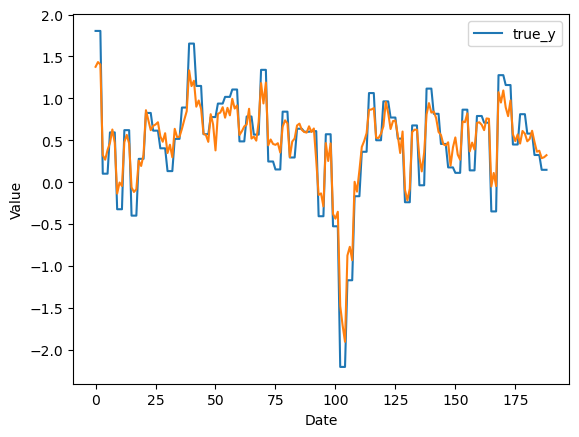

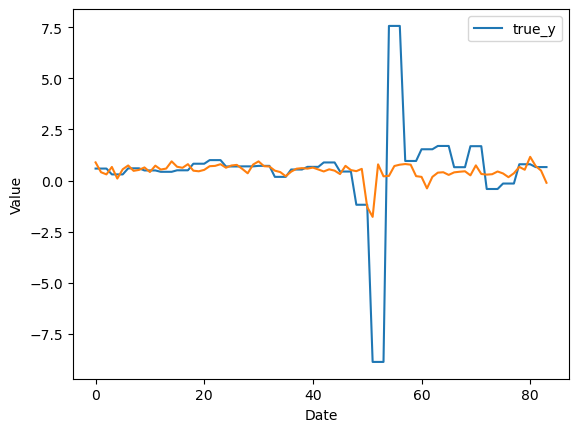

In [142]:
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(train_X, train_y)
nowcast_RF_M = regr.predict(test_X)

# in sample
plt.plot(train_y, label='true_y')
plt.plot(regr.predict(train_X))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

#out of sample (Without retune)
plt.plot(test_y, label='true_y')
plt.plot(regr.predict(test_X))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

No retune RF overall:


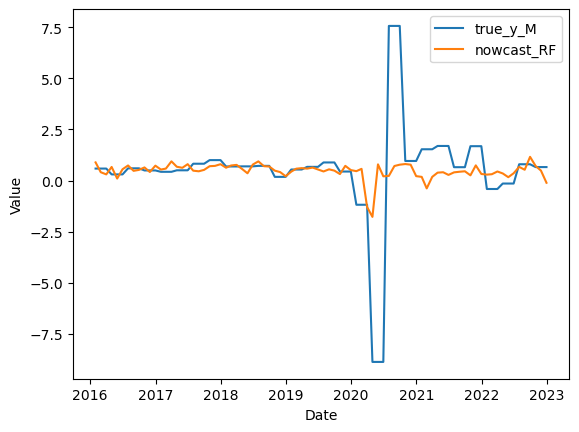

mean absolute error: 0.9399480473191643
mean absolute percentage error: 0.6387994089769944
root mean square error: 2.1884034096751623
real time root-mean-squared-forecast-error: [0.3018980445685173, 0.2480215227404814, 0.26083097868548355, 0.2901293232438565, 0.27490406229911835, 0.2711263689127604, 0.2564684950100862, 0.24381625781783767, 0.23127858679693497, 0.2242986832296368, 0.21511111806552868, 0.21671001799513934, 0.2104396225916384, 0.2071531752648581, 0.23975278172832096, 0.23618429046192954, 0.23103742058285265, 0.23540753520263574, 0.242023846666348, 0.24999140233073794, 0.25262240059543684, 0.2548456767041638, 0.25610751036441204, 0.2539991092791045, 0.2491742528522894, 0.24450780546456874, 0.24039240915483548, 0.23719388709102252, 0.24139368065044925, 0.23788435076955206, 0.2373164287897904, 0.23359584378775464, 0.23009465346009192, 0.23261891244526686, 0.23264031806174443, 0.22944084074246815, 0.22698061290685764, 0.22406654118457056, 0.22143930624291885, 0.21907866225593

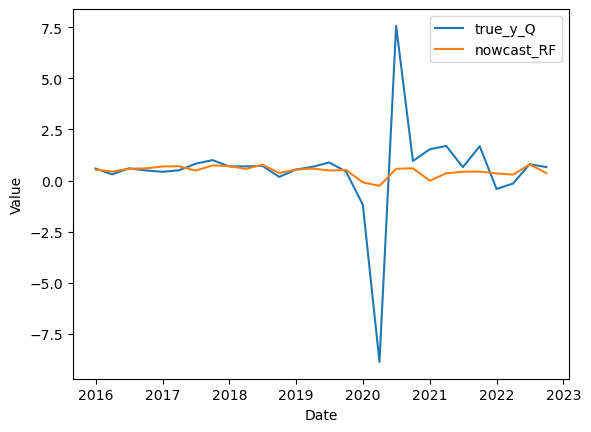

mean absolute error: 0.9000456451876516
mean absolute percentage error: 0.5682805087355386
root mean square error: 2.166337526365469
real time root-mean-squared-forecast-error: [0.053799106096862004, 0.10443761758434413, 0.08605749093602434, 0.09012256275005656, 0.14146638310626747, 0.15251753148818203, 0.1901061992517056, 0.20016114979293276, 0.18883870088233137, 0.18340300044781244, 0.17572214223954344, 0.1768885532105506, 0.1699491105776514, 0.16527152183030644, 0.18905142947567602, 0.18400312609899866, 0.3201891344464649, 2.0527245272988504, 2.561710326697734, 2.498125148770329, 2.460907116673368, 2.421117504117781, 2.368364814973601, 2.3322877950435985, 2.290219851931283, 2.2473687785560736, 2.2053592483114492]
mean directional accuracy: 0.6296296296296297
whole mean directional accuracy: 0.76
No retune RF overall before:


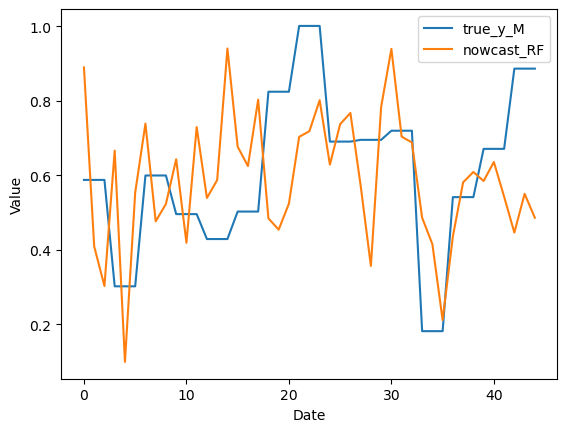

mean absolute error: 0.19453284288825862
mean absolute percentage error: 0.3813543528805418
root mean square error: 0.23113817580825302
real time root-mean-squared-forecast-error: [0.3018980445685173, 0.2480215227404814, 0.26083097868548355, 0.2901293232438565, 0.27490406229911835, 0.2711263689127604, 0.2564684950100862, 0.24381625781783767, 0.23127858679693497, 0.2242986832296368, 0.21511111806552868, 0.21671001799513934, 0.2104396225916384, 0.2071531752648581, 0.23975278172832096, 0.23618429046192954, 0.23103742058285265, 0.23540753520263574, 0.242023846666348, 0.24999140233073794, 0.25262240059543684, 0.2548456767041638, 0.25610751036441204, 0.2539991092791045, 0.2491742528522894, 0.24450780546456874, 0.24039240915483548, 0.23719388709102252, 0.24139368065044925, 0.23788435076955206, 0.2373164287897904, 0.23359584378775464, 0.23009465346009192, 0.23261891244526686, 0.23264031806174443, 0.22944084074246815, 0.22698061290685764, 0.22406654118457056, 0.22143930624291885, 0.219078662255

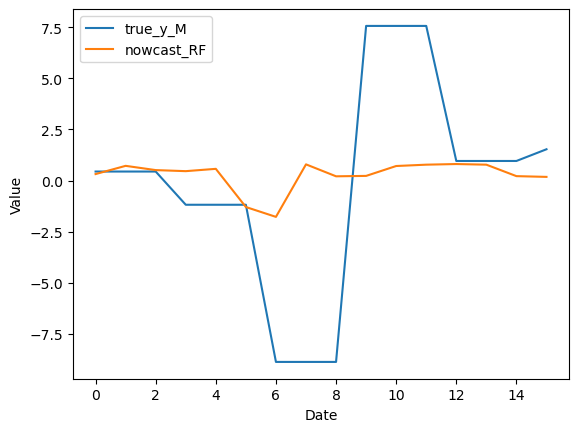

mean absolute error: 3.3247100343516918
mean absolute percentage error: 0.7327757102770376
root mean square error: 4.87947629846261
real time root-mean-squared-forecast-error: [0.12404200440539698, 0.21544079380738174, 0.1805428742689299, 0.8361333802852104, 1.0844207318686117, 0.9909694244545629, 2.832975298121606, 4.322541100572442, 5.075260206515958, 5.344065689021762, 5.4979460629387615, 5.616345249639037, 5.396170143948329, 5.200104476313576, 5.027424353364134]
mean directional accuracy: 0.2
whole mean directional accuracy: 0.46153846153846156
No retune DFM overall after:


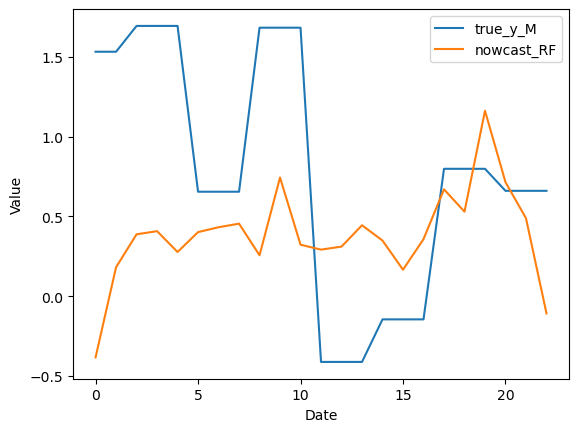

mean absolute error: 0.7394042389222212
mean absolute percentage error: 1.0771214395656752
root mean square error: 0.9072762611194191
real time root-mean-squared-forecast-error: [1.913577627565274, 1.6556597268606414, 1.5475384851920182, 1.4862704773300666, 1.472396299061496, 1.348068312688333, 1.250898051481436, 1.1722410413749829, 1.202943816364502, 1.179140252801631, 1.1965835083173113, 1.16348446610961, 1.1356376753863, 1.1179704405588748, 1.087548865240086, 1.0558782803479685, 1.0315697154952812, 1.0029632675455478, 0.9781545017153477, 0.9568406654269296, 0.9338553537228161, 0.9131179228831013]
mean directional accuracy: 0.18181818181818182
whole mean directional accuracy: 0.5


In [145]:
# DFM: saving data & plot#
# WITHOUT RETUNE

# saving data
nowcast_RF = pd.DataFrame({"Monthly nowcasting":nowcast_RF_M}, index=combined_m.loc["2016-01-01":].index)
nowcast_RF.to_csv("/Users/xuyiqi/Desktop/results/nowcast_RF_S3.csv")


nowcast_RF_M_before = nowcast_RF_M[:45]
nowcast_RF_M_during = nowcast_RF_M[45:61]
nowcast_RF_M_after = nowcast_RF_M[61:]


#
print("No retune RF overall:")

plt.plot(true_y_M['RGDP growth'], label='true_y_M')
plt.plot(nowcast_RF['Monthly nowcasting'], label='nowcast_RF')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist(), nowcast_RF_M)

#
print("No retune RF aggregated overall:")

nowcast_RF_agg = nowcast_RF.resample("Q").mean()
nowcast_RF_agg = nowcast_RF_agg.shift(-1,freq="Q").shift(+1,freq="D")

plt.plot(true_y_Q['RGDP growth'], label='true_y_Q')
plt.plot(nowcast_RF_agg['Monthly nowcasting'], label='nowcast_RF')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_Q['RGDP growth'].tolist(), nowcast_RF_agg['Monthly nowcasting'].tolist())

#
print("No retune RF overall before:")

plt.plot(true_y_M['RGDP growth'].tolist()[:45], label='true_y_M')
plt.plot(nowcast_RF_M[:45], label='nowcast_RF')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[:45], nowcast_RF_M[:45])
#
print("No retune RF overall during:")

plt.plot(true_y_M['RGDP growth'].tolist()[45:61], label='true_y_M')
plt.plot(nowcast_RF_M[45:61], label='nowcast_RF')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[45:61], nowcast_RF_M[45:61])
#
print("No retune DFM overall after:")

plt.plot(true_y_M['RGDP growth'].tolist()[61:], label='true_y_M')
plt.plot(nowcast_RF_M[61:], label='nowcast_RF')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

ofsperformance(true_y_M['RGDP growth'].tolist()[61:], nowcast_RF_M[61:])


NoRetune M1


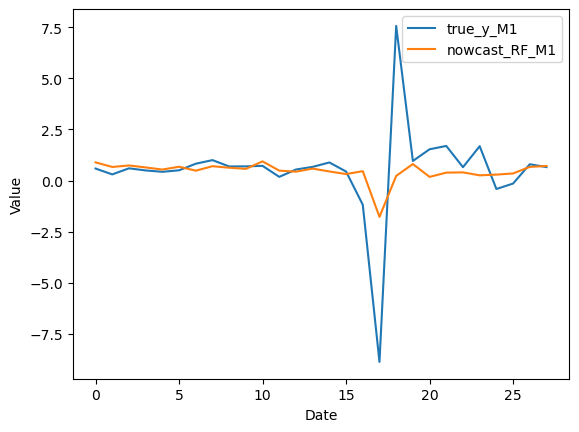

overall
mean absolute error: 0.9023922797156196
mean absolute percentage error: 0.6597979900072056
root mean square error: 2.01823340112983
real time root-mean-squared-forecast-error: [0.3018980445685173, 0.33447281489828556, 0.2846750795920537, 0.2572987725440162, 0.2353528000478566, 0.22629702540057642, 0.24573406928047647, 0.2528181221913877, 0.23924838093718231, 0.2302552131533953, 0.22930674378366595, 0.23647643672898114, 0.22906986381898678, 0.22193759664119958, 0.24264686377424485, 0.23697955164278714, 0.4600024204865916, 1.7302112705559247, 2.38030674875114, 2.3202781673632336, 2.2834550284184725, 2.248228717236552, 2.199443474833861, 2.172691866595137, 2.133434591923939, 2.0942412457574893, 2.055241975888783]
mean directional accuracy: 0.5925925925925926
whole mean directional accuracy: 0.64
before
mean absolute error: 0.2142801304597457
mean absolute percentage error: 0.441970084301074
root mean square error: 0.24264686377424485
real time root-mean-squared-forecast-error: [0.

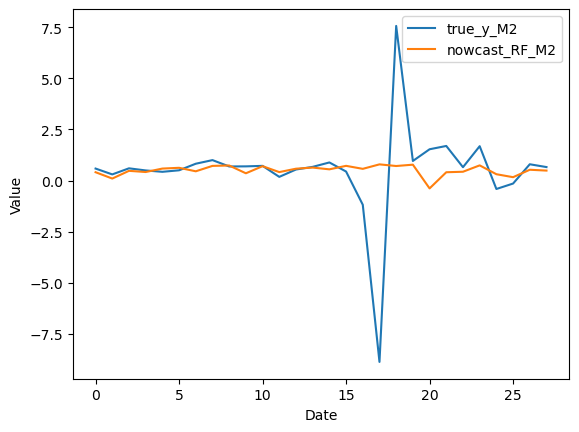

overall
mean absolute error: 0.9684013957877982
mean absolute percentage error: 0.5983128389615702
root mean square error: 2.3222495568309474
real time root-mean-squared-forecast-error: [0.17856909634849977, 0.19111258813819001, 0.17145102388237005, 0.15336891149681353, 0.15437575750914148, 0.1494779764264899, 0.19677424071283336, 0.20940869250924002, 0.19804784414535442, 0.21623056623960454, 0.20622350027017, 0.20862038525962426, 0.20073771590237563, 0.19366449567147356, 0.20623609944049778, 0.21145965677616033, 0.4727148427295411, 2.3225160893338117, 2.7530327475147662, 2.6836293510956835, 2.65203524017708, 2.6055053850683496, 2.5486567250390673, 2.5023324808882683, 2.456024618199911, 2.4091017173850284, 2.3646325442269682]
mean directional accuracy: 0.5555555555555556
whole mean directional accuracy: 0.72
before
mean absolute error: 0.17064770189707884
mean absolute percentage error: 0.3364491954153327
root mean square error: 0.20623609944049778
real time root-mean-squared-forecast-

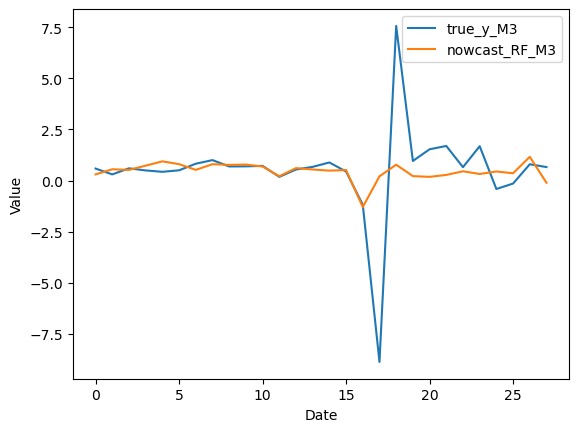

overall
mean absolute error: 0.9490504664540749
mean absolute percentage error: 0.6582873979622068
root mean square error: 2.213869775934442
real time root-mean-squared-forecast-error: [0.2847262665106036, 0.26857482850891745, 0.2236828102499318, 0.22619684863407372, 0.3053217549447077, 0.3044603648241149, 0.30388961356806843, 0.29287819846640445, 0.2773135315596983, 0.26456336114915524, 0.2524300573315522, 0.24183822677137295, 0.23310398098763474, 0.22722608663037772, 0.24261850658182038, 0.23557294691812591, 0.23011437000475018, 2.150577410078268, 2.6083689708946554, 2.5477235682674237, 2.503697708549193, 2.464680516932277, 2.4108655494067315, 2.3763460018889715, 2.3346156025632836, 2.291396958285894, 2.2496497122925687]
mean directional accuracy: 0.4074074074074074
whole mean directional accuracy: 0.56
before
mean absolute error: 0.19867069630795134
mean absolute percentage error: 0.3656437789252189
root mean square error: 0.24261850658182038
real time root-mean-squared-forecast-err

In [146]:
# Non retune
nowcast_RF_M1 = nowcast_RF_M[0::3]
nowcast_RF_M2 = nowcast_RF_M[1::3]
nowcast_RF_M3 = nowcast_RF_M[2::3]
true_y_M1 = true_y_M['RGDP growth'].tolist()[0::3]
true_y_M2 = true_y_M['RGDP growth'].tolist()[1::3]
true_y_M3 = true_y_M['RGDP growth'].tolist()[2::3]

#
print("NoRetune M1")

plt.plot(true_y_M1, label='true_y_M1')
plt.plot(nowcast_RF_M1, label='nowcast_RF_M1')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M1, nowcast_RF_M1)
print("before")
ofsperformance(true_y_M1[:15], nowcast_RF_M1[:15])
print("during")
ofsperformance(true_y_M1[15:19], nowcast_RF_M1[15:19])
print("after")
ofsperformance(true_y_M1[19:], nowcast_RF_M1[19:])
#
print("NoRetune M2")

plt.plot(true_y_M2, label='true_y_M2')
plt.plot(nowcast_RF_M2, label='nowcast_RF_M2')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M2, nowcast_RF_M2)
print("before")
ofsperformance(true_y_M2[:15], nowcast_RF_M2[:15])
print("during")
ofsperformance(true_y_M2[15:19], nowcast_RF_M2[15:19])
print("after")
ofsperformance(true_y_M2[19:], nowcast_RF_M2[19:])

#
print("NoRetune M3")

plt.plot(true_y_M3, label='true_y_M3')
plt.plot(nowcast_RF_M3, label='nowcast_RF_M3')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

print("overall")
ofsperformance(true_y_M3, nowcast_RF_M3)
print("before")
ofsperformance(true_y_M3[:15], nowcast_RF_M3[:15])
print("during")
ofsperformance(true_y_M3[15:19], nowcast_RF_M3[15:19])
print("after")
ofsperformance(true_y_M3[19:], nowcast_RF_M3[19:])

In [80]:
# Random Forest

y_train = y_total.loc[:"2015-12-31"]

X_train_M = combined_m.loc[:"2016-01-01"] 
X_train_D = D_data.loc[:"2015-12-31"]
X_train_W = W_data.loc[:"2015-12-31"]

y_test= y_total.loc["2015-12-31":]

X_test_M = combined_m.loc["2016-01-01":] 
X_test_D = D_data.loc["2016-01-01":]
X_test_W = W_data.loc["2016-01-01":]

In [81]:
def supToMonth(D):
    currentMonth = None
    counter = 0
    data = []
    figure = 0
    for idx in D.index:
        date = idx.date().strftime('%Y-%m-%d')
        month = date[:-3]
        #print(month)
        #print(month)
        if currentMonth == None:
            currentMonth = month
                
        if month != currentMonth:
            #new month
            #print('cur'+currentMonth)
            data.append(figure/counter)
            
            figure = D.loc[date].to_numpy()
            counter = 1
            currentMonth = month
        else:
            figure += D.loc[date].to_numpy()
            counter += 1
    
    data.append(figure/counter) #finishing up
    
    return np.array(data)

def raiseToMonth(D):
    data = []
    for idx in D.index:
        tmp = [D.loc[idx].to_numpy()] * 3
        data += tmp
    return np.array(data)

In [82]:
y = raiseToMonth(y_train)

In [83]:
train_X = np.concatenate((X_train_M.to_numpy()[2:,:], supToMonth(X_train_D)[3:,:], supToMonth(X_train_W)[3:,:]), axis=1)
train_y = raiseToMonth(y_train)
test_X = np.concatenate((X_test_M.to_numpy(), supToMonth(X_test_D), supToMonth(X_test_W)), axis=1)
test_y = raiseToMonth(y_test[1:])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(189, 15) (189, 1) (84, 15) (84, 1)


In [86]:
meta_train_X = np.concatenate((train_X, test_X), axis = 0)
meta_train_y = np.concatenate((train_y, test_y), axis = 0)
print(meta_train_X.shape, meta_train_y.shape)

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(meta_train_X[2:189,:], meta_train_y[2:189,:].squeeze(1))

(273, 15) (273, 1)


RandomForestRegressor(max_depth=10, random_state=0)

In [106]:
from copy import deepcopy
#lag 1
lagged_meta_X = deepcopy(meta_train_X[5:,:])
aug_X = deepcopy(meta_train_y[2:-3,:])
augmented_meta_X = np.concatenate((lagged_meta_X, aug_X), axis = 1)
augmented_meta_y = deepcopy(meta_train_y[5:,:])

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(augmented_meta_X, augmented_meta_y.squeeze(1))
nowcast_RF_M = regr.predict(augmented_meta_X[184:,:])

In [91]:
bridge_res1 = np.load('bridge_res1.npy')
DFM_res1 = np.load('DFM_res1.npy')
RF_res1 = np.load('RF_res1.npy')


In [107]:
bridge_res = np.array(true_y_M['RGDP growth'].tolist()) - np.array(nowcast_M)
DFM_res = np.array(true_y_M['RGDP growth'].tolist()) - np.array(nowcast_DFM_M)
RF_res = np.array(true_y_M['RGDP growth'].tolist()) - np.array(nowcast_RF_M)

In [108]:
import numpy as np
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(bridge_res1, bridge_res)

# Print results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(DFM_res1, DFM_res)

# Print results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t_statistic, p_value = ttest_ind(RF_res1, RF_res)

# Print results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.13124032186105586
p-value: 0.8957441209067609
t-statistic: 0.12382988264354089
p-value: 0.9015997819209309
t-statistic: 0.21855649024074786
p-value: 0.8272640135693354


In [109]:
Date = true_y_Q.index
bn = rmsfe(true_y_Q['RGDP growth'].tolist(), nowcast_bridge_agg['Monthly nowcasting'].tolist())

dn = rmsfe(true_y_Q['RGDP growth'].tolist(), nowcast_DFM_agg['Monthly nowcasting'].tolist())
rn = rmsfe(true_y_Q['RGDP growth'].tolist(), nowcast_RF_agg['Monthly nowcasting'].tolist())

fig = go.Figure()
# Create and style traces

fig.add_trace(go.Scatter(x=Date, y=bn, name = 'Bridge Equation',
                         line=dict(color='black', width=1.5)))

fig.add_trace(go.Scatter(x=Date, y=dn, name='Dynamic Factor Model',
                         line=dict(color='green', width=1.5
                                  ) # dash options include 'dash', 'dot', and 'dashdot'
))
fig.add_trace(go.Scatter(x=Date, y=rn, name='Random Forests',
                         line = dict(color='royalblue', width=1.5)))

# Edit the layout
fig.update_layout(title='Real Time Root-mean-squared-forecast-error',
                   xaxis_title='Date',
                   yaxis_title='RT-RMSFE')


fig.show()

NameError: name 'nowcast_RF_agg' is not defined